A concerning consequence of gentrification is displacement of long term residents in neighborhoods who are "priced out" by the new cash flow and attraction of the area.

This case study involves using new construction permits as a proxy for gentrification. While policy experts agree that there are many drivers of gentrification, new construction permits is one strong factor that heavily indicates an increase in investment and attention too a certain neighborhood of a city. In this study, we identify where new construction permits are filed in the city of Philadelphia between 2010-2019 to predict where future permits will be filed in 2019.

The model created below is intended to help fair housing agencies who provide services and resources to individuals at risk of home foreclosure maintain ownership status of their homes. Specifically, the model is able to predict in which neighborhoods more construction permits will be filed and ultimately which are at risk of gentrification and potential displacement.
Fair housing agencies will be able to use the tool to help existing clients as well as conduct outreach to new clients who they know may soon struggle financially due to increasing property taxes or other lower costs of living.

In [1]:
# load libraries

knitr::opts_chunk$set(warning=FALSE, message=FALSE, class.source = "fold-hide")

library(tidyverse)
library(sf)
library(RSocrata)
library(viridis)
library(spatstat)
library(raster)
library(spdep)
library(FNN)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tidycensus)

options(scipen=999)

mapTheme <- function(base_size = 12) {
    theme(
        text = element_text(color = "black"),
        plot.title = element_text(size = "14", color = "black"),
        plot.subtitle = element_text(face = "italic"),
        plot.caption = element_text(hjust = 0),
        axis.ticks = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_rect(color = "black", fill = NA, size = 2)
    )
}

plotTheme <- function(base_size = 12){
    theme(
        text = element_text(color = "black"),
        plot.title = element_text(size = "14", color = "black"),
        plot.subtitle = element_text(face = "italic"),
        plot.caption = element_text(hjust = 0),
        axis.ticks = element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_line("grey80", size = 0.1),
        panel.grid.minor = element_blank(),
        panel.border = element_rect(color = "black", fill = NA, size = 2),
        strip.background = element_rect(fill = "grey80", color = "white"),
        strip.text = element_text(size=12),
        axis.title = element_text(size=12),
        axis.text = element_text(size=10),
        plot.background = element_blank(),
        legend.background = element_blank(),
        legend.title = element_text(colour = "black", face = "italic"),
        legend.text = element_text(colour = "black", face = "italic"),
        strip.text.x = element_text(size = 14)
    )
}

qBr <- function(df, variable, rnd){
    if (missing(rnd)) {
        as.character(quantile(round(df[[variable]], 0), c(.01, .2,.4, .6, .8), na.rm=T))
    } else if (rnd == FALSE || rnd == F) {
        as.character(formatC(quantile(df[[variable]]), digits = 3), c(.01, .2, .4, .6, .8), na.rm = T)
    }
}

q5 <- function(variable) {as.factor(ntile(variable ,5))}

palette5 <- c("#d01c8b","#f1b6da","#b8e186","#4dac26","#f7f7f7")
palette4 <- c("#d01c8b","#f1b6da","#b8e186","#4dac26")
palette2 <- c("#a1d76a","#e9a3c9")
constructionpalette <- c("#090a07", "#383120", "#c7b897", "#de9f00", "#fdcc00")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1; sf_use_s2() is TRUE

Loading required package: viridisLite

Loading required package: spatstat.data

Loading required package: spatstat.geom

spatstat.geom 2.4-0

Loading required package: spatstat.random

spatstat.random 2.2-0

Loading required package: spatstat.core

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: rpart

spatstat.core 2.4-2

Loading required package: spatstat.linnet

spatstat.linnet 2.3-2


spatstat 2.3-4       (nickname: ‘Watch this sp

Reading layer `OGRGeoJSON' from data source 
  `https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+permits+WHERE+permitissuedate+>=+'2010-01-01'+AND+permitissuedate+<+'2019-01-01'AND+typeofwork+=+'NEW+CONSTRUCTION'&filename=permits&format=geojson&skipfields=cartodb_id' 
  using driver `GeoJSON'
replacing null geometries with empty geometries
Simple feature collection with 5019 features and 31 fields (with 168 geometries empty)
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -75.27125 ymin: 39.88057 xmax: -74.96128 ymax: 40.13268
Geodetic CRS:  WGS 84
Reading layer `abf6322f-732c-41eb-be2f-a687a95d16462020329-1-11fkgla.x0gkf' from data source `http://data.phl.opendata.arcgis.com/datasets/063f5f85ef17468ebfebc1d2498b7daf_0.geojson' 
  using driver `GeoJSON'
Simple feature collection with 288 features and 4 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -75.28031 ymin: 39.86771 xmax: -74.95575 ymax: 40.13793
Geodetic CRS:  WGS 84
Reading layer `Census_Block

[1] "double"

Reading layer `Neighborhoods_Philadelphia' from data source 
  `https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson' 
  using driver `GeoJSON'
Simple feature collection with 158 features and 8 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -75.28027 ymin: 39.867 xmax: -74.95576 ymax: 40.13799
Geodetic CRS:  WGS 84


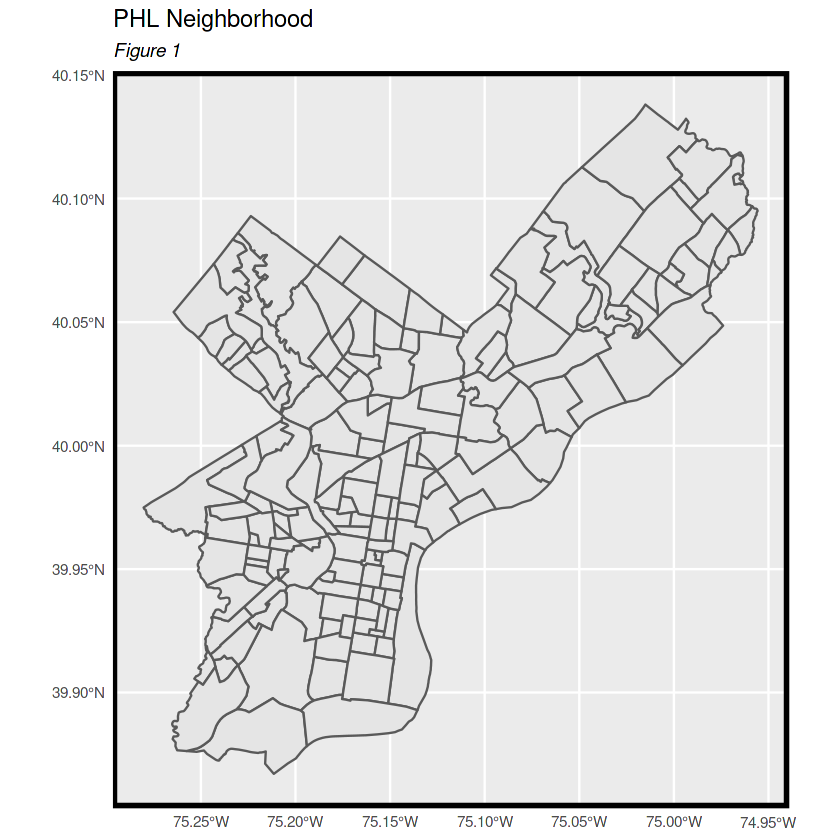

In [2]:
# permit data, PHL boundary, PHL block groups, PHL nhoods, base fishnet

permits <- st_read("https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+permits+WHERE+permitissuedate+>=+'2010-01-01'+AND+permitissuedate+<+'2019-01-01'AND+typeofwork+=+'NEW+CONSTRUCTION'&filename=permits&format=geojson&skipfields=cartodb_id") %>%
    st_transform('EPSG:3857')

phlBound <- st_read("http://data.phl.opendata.arcgis.com/datasets/063f5f85ef17468ebfebc1d2498b7daf_0.geojson") %>%
    st_transform('EPSG:3857')

phlblockgroups <- st_read("http://data.phl.opendata.arcgis.com/datasets/2f982bada233478ea0100528227febce_0.geojson") %>%
    st_transform('EPSG:3857') %>%
    rename(GEOID = GEOID10)

phlblockgroups <- transform(phlblockgroups, GEOID = as.double(GEOID))

typeof(phlblockgroups$GEOID)

neighborhoods <- st_read("https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson") %>%
    st_transform('EPSG:3857')

ggplot() +
    geom_sf(data = neighborhoods) +
    labs(title = "PHL Neighborhood", subtitle = "Figure 1") +
    mapTheme()

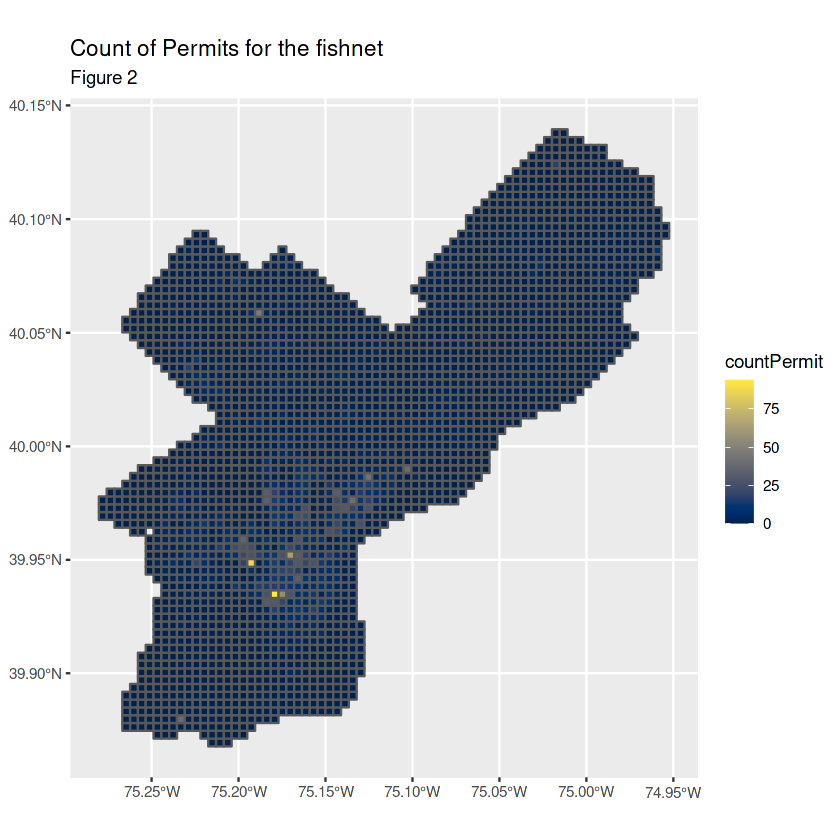

In [3]:
# Create a fishnet grid and sum up the counts of permits per gridcell and join it to the fishnet

fishnet <- st_make_grid(phlBound, cellsize = 500, square = TRUE) %>%
    .[phlBound] %>% st_sf() %>%
    mutate(uniqueID = rownames(.))

permit_net <- dplyr::select(permits) %>% mutate(countPermit = 1) %>%
    aggregate(., fishnet, sum) %>%
    mutate(countPermit = replace_na(countPermit, 0),
            uniqueID = rownames(.),
            cvID = sample(round(nrow(fishnet) / 24),
                       size = nrow(fishnet), replace = TRUE))

ggplot() +
    geom_sf(data = permit_net, aes(fill = countPermit)) + 
    scale_fill_viridis(option = "cividis") +
    labs(title = "Count of Permits for the fishnet", subtitle = "Figure 2")

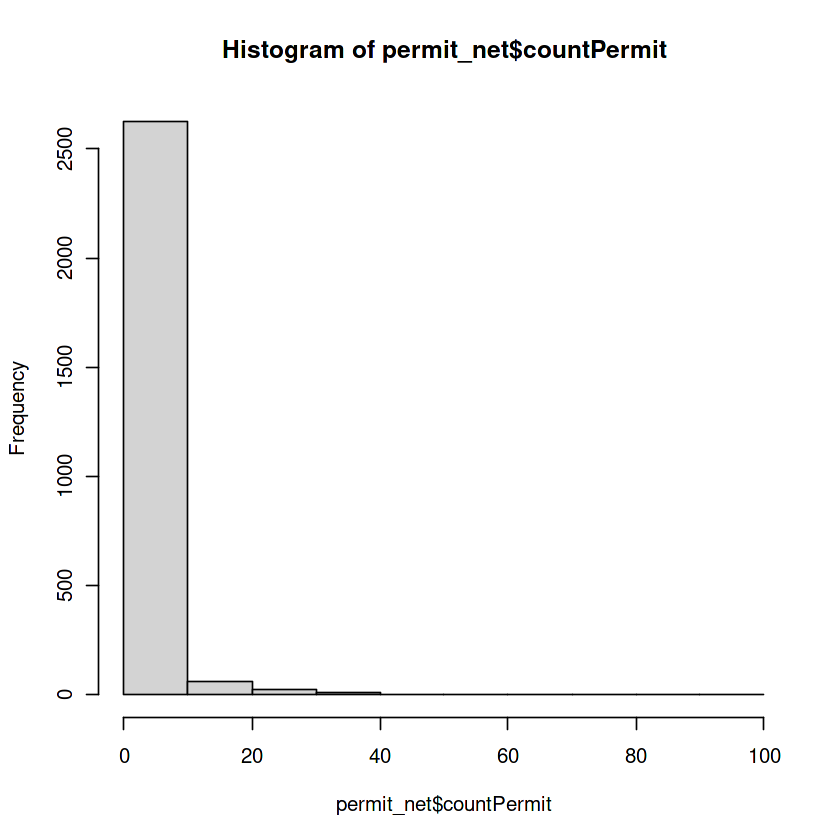

In [4]:
hist(permit_net$countPermit)

## Feature Engineering

in this section, each feature is described and we explain whethere or not it was included in the model and why.

In [5]:
pablockgroups <- read.csv("../input/pablockgroups/PA_block-groups.csv") %>% 
    filter(parent.location == "Philadelphia County, Pennsylvania")

pablockgroups <- pablockgroups %>% filter(year == 2010 | year == 2014 | year == 2016)
head(pablockgroups, 10)

,GEOID,year,name,parent.location,population,poverty.rate,renter.occupied.households,pct.renter.occupied,median.gross.rent,median.household.income,⋯,pct.nh.pi,pct.multiple,pct.other,eviction.filings,evictions,eviction.rate,eviction.filing.rate,low.flag,imputed,subbed
,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>
1,421010001001,2010,1.1,"Philadelphia County, Pennsylvania",1633,7.85,831,75.20,1401,64208,⋯,0.00,2.14,0.00,16,13,1.56,1.93,0,0,1
2,421010001002,2010,1.2,"Philadelphia County, Pennsylvania",1845,0.00,652,54.52,1609,93021,⋯,0.11,1.90,0.27,8,5,0.77,1.23,0,0,1
3,421010002001,2010,2.1,"Philadelphia County, Pennsylvania",2937,5.07,781,68.21,905,49928,⋯,0.03,1.40,0.31,6,1,0.13,0.77,0,0,1
4,421010003001,2010,3.1,"Philadelphia County, Pennsylvania",693,10.58,373,97.64,1988,76354,⋯,0.00,2.02,0.43,11,5,1.34,2.95,0,0,1
5,421010003002,2010,3.2,"Philadelphia County, Pennsylvania",2476,6.49,1029,69.86,1741,66524,⋯,0.04,2.67,0.28,13,8,0.78,1.26,0,0,1
6,421010004011,2010,4.01.1,"Philadelphia County, Pennsylvania",2125,44.44,1240,78.28,965,30000,⋯,0.00,2.96,0.14,32,11,0.89,2.58,0,0,1
7,421010004021,2010,4.02.1,"Philadelphia County, Pennsylvania",1089,15.50,78,9.15,716,31500,⋯,0.00,0.37,0.37,0,0,0.00,0.00,0,0,1
8,421010004022,2010,4.02.2,"Philadelphia County, Pennsylvania",2053,0.00,809,56.93,1597,52009,⋯,0.19,1.46,0.19,7,2,0.25,0.87,0,0,1
9,421010005001,2010,5.1,"Philadelphia County, Pennsylvania",2329,0.00,639,93.42,1073,45734,⋯,0.09,2.02,0.30,39,12,1.88,6.10,0,0,1


In [6]:
nrow(pablockgroups)

[1] 1336

In [7]:
nrow(phlblockgroups)

[1] 1336

In [8]:
evictions.geom <- left_join(pablockgroups, phlblockgroups, by = "GEOID") %>%
    st_as_sf() %>% # generate interpolation to grid cell
    st_transform('EPSG:3857') %>%
    mutate(Legend = "Evictions")

In [9]:
blockgroups <- read.csv("../input/blockgroups/block-groups.csv") %>%
    filter(year == 2010 | year == 2014 | year == 2016)

blockgroups <- blockgroups %>% filter(parent.location == "Philadelphia County, Pennsylvania")

In [10]:
head(blockgroups, 5)

,GEOID,year,name,parent.location,population,poverty.rate,renter.occupied.households,pct.renter.occupied,median.gross.rent,median.household.income,⋯,pct.nh.pi,pct.multiple,pct.other,eviction.filings,evictions,eviction.rate,eviction.filing.rate,low.flag,imputed,subbed
,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,421010001001,2010,1.1,"Philadelphia County, Pennsylvania",1633,7.85,831,75.20,1401,64208,⋯,0.00,2.14,0.00,16,13,1.56,1.93,0,0,1
2,421010001001,2014,1.1,"Philadelphia County, Pennsylvania",1782,0.00,912,75.66,1469,90898,⋯,0.00,2.81,0.00,13,4,0.44,1.42,0,0,1
3,421010001001,2016,1.1,"Philadelphia County, Pennsylvania",1782,0.00,953,75.66,1469,90898,⋯,0.00,2.81,0.00,17,10,1.05,1.78,0,0,1
4,421010001002,2010,1.2,"Philadelphia County, Pennsylvania",1845,0.00,652,54.52,1609,93021,⋯,0.11,1.90,0.27,8,5,0.77,1.23,0,0,1
5,421010001002,2014,1.2,"Philadelphia County, Pennsylvania",1826,0.00,734,66.15,1645,100259,⋯,0.00,2.19,0.00,13,8,1.09,1.77,0,0,1


In [11]:
nrow(blockgroups)

[1] 4008

In [12]:
evictions.geom <- left_join(blockgroups, phlblockgroups, by = "GEOID") %>%
    st_as_sf() %>% # generate interpolation to grid cell
    st_transform('EPSG:3857') %>%
    mutate(Legend = "Evictions")

In [13]:
nrow(evictions.geom)

[1] 4008

In [14]:
# Average number of evictions per grid cell
evictions_net <- evictions.geom %>%
    st_sf() %>% 
    mutate(evictionsTotal = ifelse(is.na(evictions.geom$evictions), 0, evictions.geom$evictions)) %>%
    dplyr::select(evictionsTotal) %>%
    aggregate(., fishnet, mean) %>%
    mutate(Legend = "evictionsTotal")
    
# mutate the variable your after for tracts
tractJawn <- evictions.geom %>%
    st_sf() %>%
    mutate(evictionsTotal = ifelse(is.na(evictions.geom$evictions), 0, evictions.geom$evictions))

# Interpolate from tracts to fishnet. Look up the extensive parameter
interpolateJawn <- dplyr::select(tractJawn, evictionsTotal) %>%
    st_interpolate_aw(., fishnet, extensive = TRUE)

# For all vars net later
evictions_net.long <- gather(evictions_net, Variable, value, -geometry, -Legend) %>%
    dplyr::select(-Legend)

evictions_net.long <- st_join(evictions_net.long, fishnet, join = st_within)

Warning message in st_interpolate_aw.sf(., fishnet, extensive = TRUE):
“st_interpolate_aw assumes attributes are constant or uniform over areas of x”


Warning message in st_interpolate_aw.sf(., fishnet, extensive = TRUE):
“st_interpolate_aw assumes attributes are constant or uniform over areas of x”


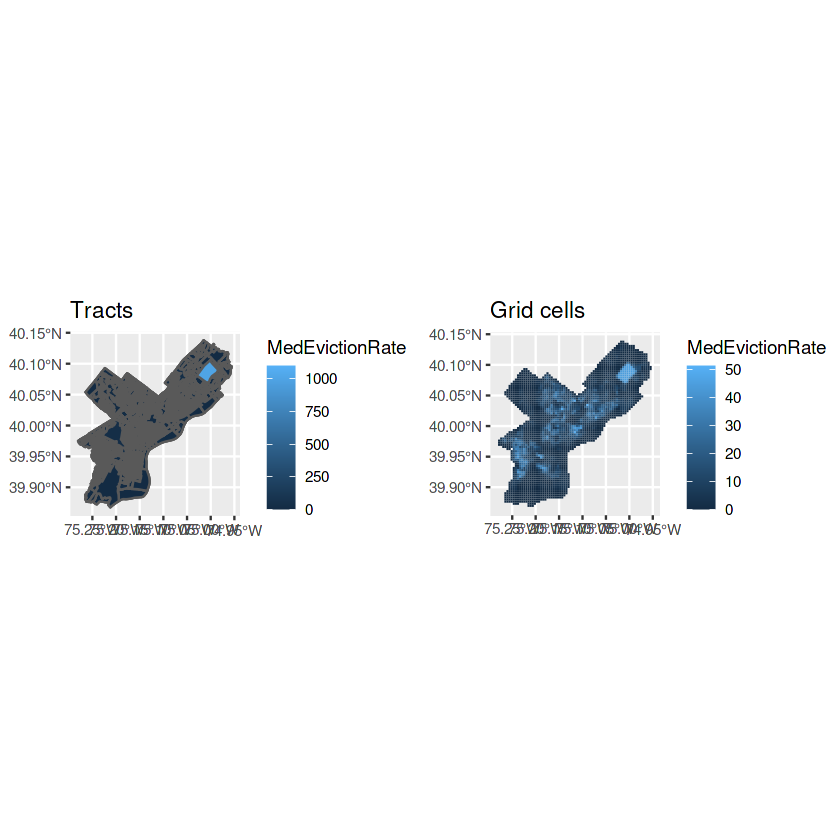

In [15]:
# Median eviction rate per grid cell
evictions_net2 <-
  evictions.geom %>%
  st_sf() %>%
   mutate(MedEvictionRate=ifelse(is.na(evictions.geom$eviction.rate),0,evictions.geom$eviction.rate))%>%
  dplyr::select(MedEvictionRate) %>% 
  aggregate(., fishnet, median)%>%
  mutate(Legend="MedEvictionRate")

#mutate the variable your after for tracts
tractJawn <- 
 evictions.geom %>%
  st_sf() %>%
  mutate(MedEvictionRate=ifelse(is.na(evictions.geom$eviction.rate),0,evictions.geom$eviction.rate))

#interpolate from tracts to fishnet. Look up the `extensive` parameter.
interpolateJawn <-
  dplyr::select(tractJawn, MedEvictionRate) %>%
  st_interpolate_aw(., fishnet, extensive = TRUE)

#for all vars net later
evictions_net2.long<-
  gather(evictions_net2, Variable, value, -geometry,-Legend)%>%
  dplyr::select(-Legend)

evictions_net2.long<-
  st_join(evictions_net2.long, fishnet, join=st_within)

#map
grid.arrange(
  ggplot() + geom_sf(data=tractJawn, aes(fill = MedEvictionRate)) + ggtitle("Tracts"),
  ggplot() + geom_sf(data=interpolateJawn, aes(fill = MedEvictionRate), colour=NA) + ggtitle("Grid cells"),
  ncol=2)

Warning message in st_interpolate_aw.sf(., fishnet, extensive = TRUE):
“st_interpolate_aw assumes attributes are constant or uniform over areas of x”


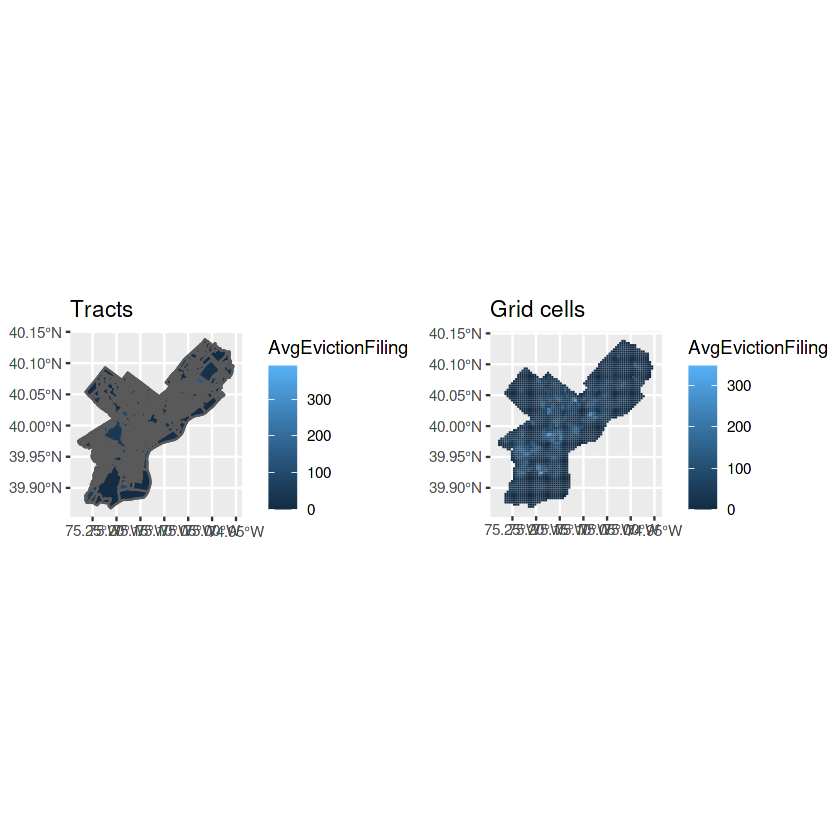

In [16]:
evictions_net3 <-
  evictions.geom %>%
  st_sf() %>%
  mutate(AvgEvictionFiling=ifelse(is.na(evictions.geom$eviction.filings),0,evictions.geom$eviction.filings))  %>%
  dplyr::select(AvgEvictionFiling) %>% 
  aggregate(., fishnet, mean)%>%
  mutate(Legend="AvgEvictionFiling")

#mutate the variable your after for tracts
tractJawn <- 
 evictions.geom %>%
  st_sf() %>%
  mutate(AvgEvictionFiling=ifelse(is.na(evictions.geom$eviction.filings),0,evictions.geom$eviction.filings))

# Interpolate form tracts to fishnet. Look up the `extensive` parameter
interpolateJawn <- dplyr::select(tractJawn, AvgEvictionFiling) %>%
    st_interpolate_aw(., fishnet, extensive = TRUE)

# for all vars net later
evictions_net3.long <- gather(evictions_net3, Variable, value, -geometry, -Legend) %>%
    dplyr::select(-Legend)

evictions_net3.long <- st_join(evictions_net3.long, fishnet, join = st_within)

# map
grid.arrange(
    ggplot() +
    geom_sf(data = tractJawn, aes(fill = AvgEvictionFiling)) +
    ggtitle("Tracts"), ggplot() +
    geom_sf(data = interpolateJawn, aes(fill = AvgEvictionFiling), color=NA)+
    ggtitle("Grid cells"), ncol=2
)

In [17]:
# Median Filing Rate per each grid cell, it has the same issue as Median Eviction Rater per grid cell
# Not included in the model

evictions_net4 <-
  evictions.geom %>%
  st_sf() %>%
  mutate(MedFilingRate=ifelse(is.na(evictions.geom$eviction.filing.rate),0,evictions.geom$eviction.filing.rate))  %>%
  dplyr::select(MedFilingRate) %>% 
  aggregate(., fishnet, median)%>%
  mutate(Legend="MedFilingRate")

#mutate the variable your after for tracts
tractJawn <- 
 evictions.geom %>%
  st_sf() %>%
  mutate(MedFilingRate=ifelse(is.na(evictions.geom$eviction.filing.rate),0,evictions.geom$eviction.filing.rate))

#interpolate from tracts to fishnet. Look up the `extensive` parameter.
interpolateJawn <-
  dplyr::select(tractJawn, MedFilingRate) %>%
  st_interpolate_aw(., fishnet, extensive = TRUE)

#for all vars net later
evictions_net4.long<-
  gather(evictions_net4, Variable, value, -geometry, -Legend)%>%
  dplyr::select(-Legend)

evictions_net4.long<-
  st_join(evictions_net4.long, fishnet, join=st_within)


Warning message in st_interpolate_aw.sf(., fishnet, extensive = TRUE):
“st_interpolate_aw assumes attributes are constant or uniform over areas of x”


## Property Tax Delinquency

Reading layer `OGRGeoJSON' from data source 
  `https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+real_estate_tax_delinquencies+WHERE+mailing_city+=+'PHILADELPHIA'&filename=real_estate_tax_delinquencies&format=geojson&skipfields=cartodb_id' 
  using driver `GeoJSON'
replacing null geometries with empty geometries
Simple feature collection with 13085 features and 53 fields (with 26 geometries empty)
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -75.26925 ymin: 39.89244 xmax: -74.9649 ymax: 40.12848
Geodetic CRS:  WGS 84


`summarise()` has grouped output by 'uniqueID'. You can override using the
`.groups` argument.


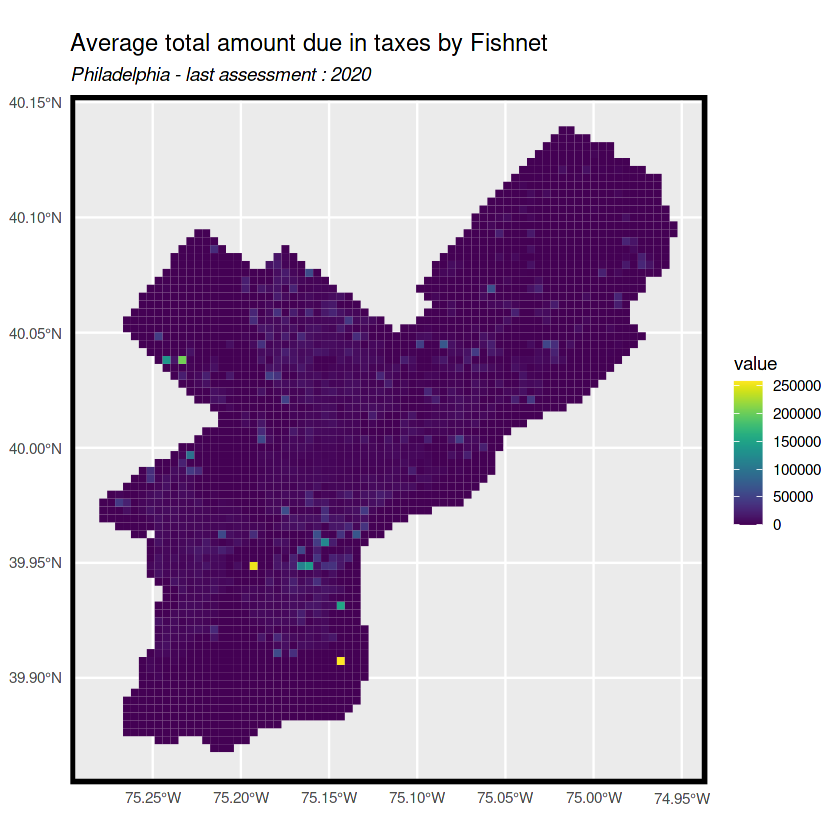

In [18]:
# total amount of taxes owed per grid cell

# Tax delinquency data
tax <- st_read("https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+real_estate_tax_delinquencies+WHERE+mailing_city+=+'PHILADELPHIA'&filename=real_estate_tax_delinquencies&format=geojson&skipfields=cartodb_id") %>%
    st_as_sf(coords = c("lon", "lat"), crs = 4326, agr = "constant") %>%
    st_transform('EPSG:3857') %>%
    mutate(Legend = "Tax")

tax_net <- st_join(tax, fishnet, join = st_within) %>%
    st_drop_geometry() %>%
    group_by(uniqueID, Legend) %>%
    summarize(totalOwed = mean(total_due, n=n()), ) %>%
    full_join(fishnet, by='uniqueID') %>%
    spread(Legend, totalOwed, fill=0) %>%
    st_sf() %>%
    dplyr::select(- `<NA>`) %>%
    na.omit() %>%
    ungroup()

tax_net.long <-
    gather(tax_net, Variable, value, -geometry, -uniqueID)

ggplot() +
    geom_sf(data = tax_net.long, aes(fill=value), color=NA) +
    scale_fill_viridis() +
    labs(title = "Average total amount due in taxes by Fishnet", subtitle = "Philadelphia - last assessment : 2020") +
    mapTheme()

`summarise()` has grouped output by 'uniqueID'. You can override using the
`.groups` argument.


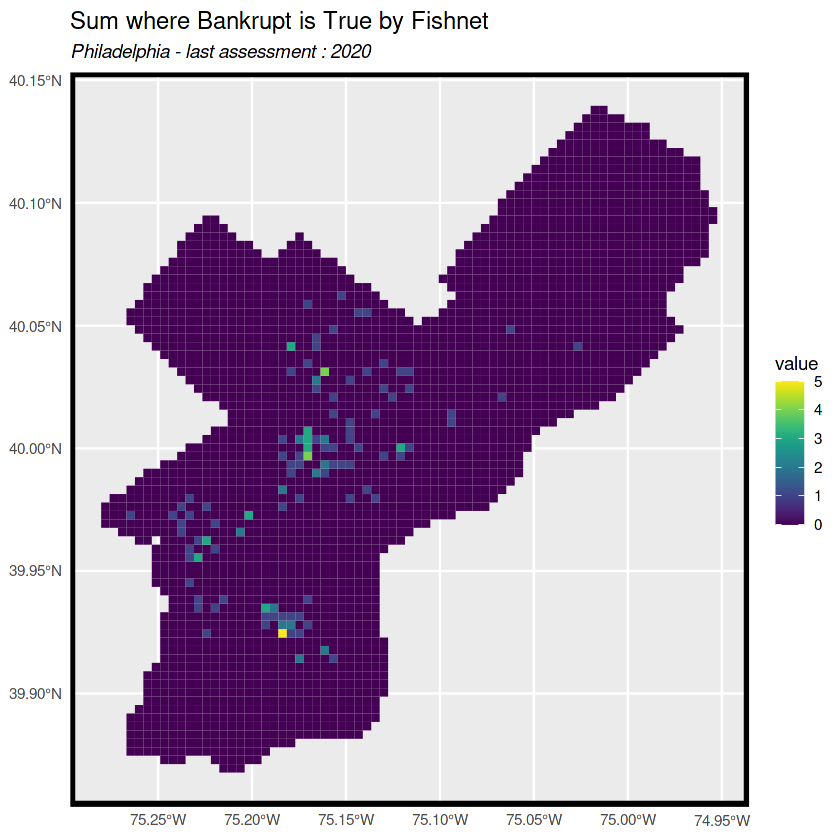

In [19]:
# total number of bankruptcy occurrences per grid cell

tax2 <- tax %>%
    mutate(Legend = "taxBankruptcy")

tax_net2 <- st_join(tax2, fishnet, join = st_within) %>%
    st_drop_geometry() %>%
    group_by(uniqueID, Legend) %>%
    summarize(bankrupt = sum(bankruptcy == 'true')) %>%
    full_join(fishnet, by='uniqueID') %>%
    spread(Legend, bankrupt, fill=0) %>%
    st_sf() %>%
    dplyr::select(- `<NA>`) %>%
    na.omit() %>%
    ungroup()

tax_net2.long <- gather(tax_net2, Variable, value, -geometry, -uniqueID)

ggplot() +
    geom_sf(data = tax_net2.long, aes(fill=value), color=NA) +
    scale_fill_viridis() +
    labs(title = "Sum where Bankrupt is True by Fishnet", subtitle = "Philadelphia - last assessment : 2020") +
    mapTheme()

`summarise()` has grouped output by 'uniqueID'. You can override using the
`.groups` argument.


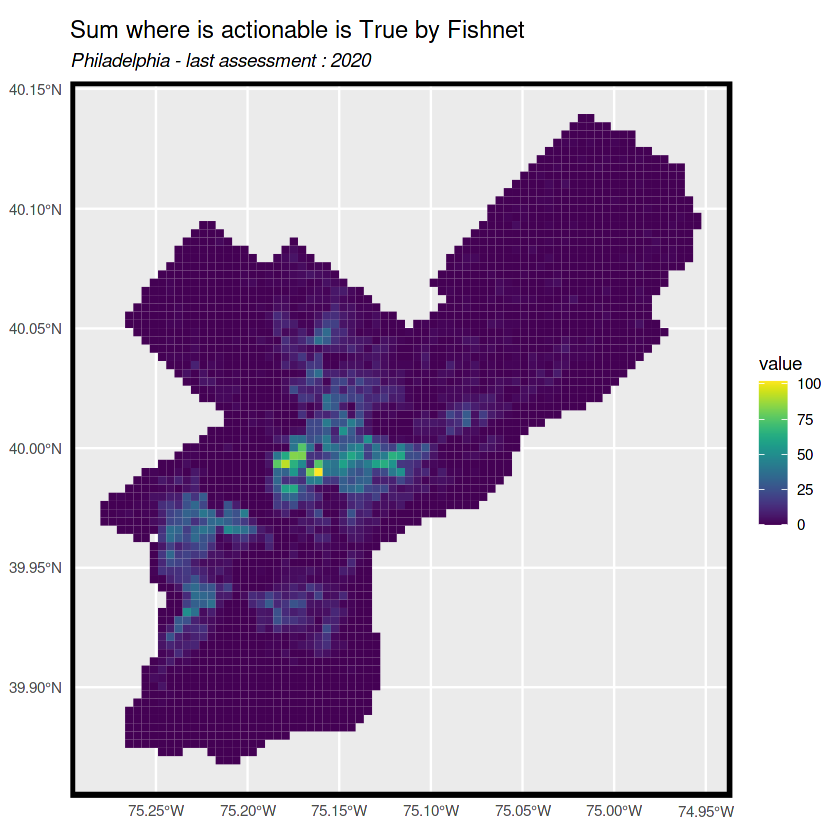

In [20]:
# accounts considered to be "actionable" per grid cell
tax3 <- tax %>%
    mutate(Legend = "taxActionable")

tax_net3 <- st_join(tax3, fishnet, join=st_within) %>%
    st_drop_geometry() %>%
    group_by(uniqueID, Legend) %>%
    summarize(actionable = sum(is_actionable == 'true')) %>%
    full_join(fishnet, by="uniqueID") %>%
    spread(Legend, actionable, fill=0) %>%
    st_sf() %>%
    dplyr::select(- `<NA>`) %>%
    na.omit() %>%
    ungroup()

tax_net3.long <-
    gather(tax_net3, Variable, value, -geometry, -uniqueID)

ggplot() +
    geom_sf(data = tax_net3.long, aes(fill=value), color=NA) +
    scale_fill_viridis() +
    labs(title = "Sum where is actionable is True by Fishnet", subtitle = "Philadelphia - last assessment : 2020") +
    mapTheme()

## Hipster Features

Starbucks cafes are strongly associated with a 0.5% increase in housing prices.
An increase in amenities like grocery stores, cafes and bars leads to an icrease in gentrification

`summarise()` has grouped output by 'uniqueID'. You can override using the
`.groups` argument.
Joining, by = "uniqueID"


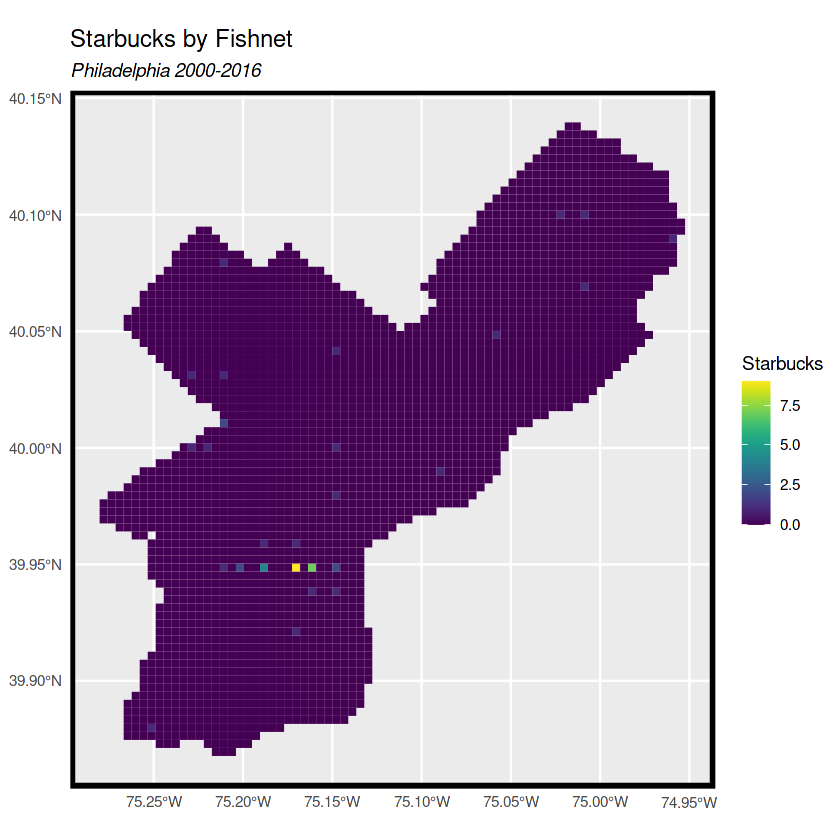

In [21]:
# starbucks locations
#Starbucks data <- kaggle datasets download -d starbucks/store-locations

starbucks <-read.csv("../input/store-locations/directory.csv")
starbucks <- filter(starbucks, City=="Philadelphia") %>%
    st_as_sf(coords = c("Longitude", "Latitude"), crs = 4326, agr = "constant") %>%
    st_transform('EPSG:3857') %>%
    mutate(Legend = "Starbucks")

starbucks_net <- st_join(starbucks, fishnet, join = st_within) %>%
    st_drop_geometry() %>%
    group_by(uniqueID, Legend) %>%
    summarize(count = n()) %>%
    full_join(fishnet) %>%
    spread(Legend, count, fill=0) %>%
    st_sf() %>%
    dplyr::select(- `<NA>`) %>%
    na.omit() %>%
    ungroup()

ggplot() +
    geom_sf(data = starbucks_net, aes(fill=Starbucks), color=NA) +
    scale_fill_viridis() +
    labs(title = "Starbucks by Fishnet", subtitle = "Philadelphia 2000-2016") +
    mapTheme()

Reading layer `370eb703-5a4f-4abb-8920-727cef31373b2020329-1-rcimn.5n39o' from data source `http://data-phl.opendata.arcgis.com/datasets/53b8a1c653a74c92b2de23a5d7bf04a0_0.geojson' 
  using driver `GeoJSON'
Simple feature collection with 1336 features and 16 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -75.28031 ymin: 39.86747 xmax: -74.95575 ymax: 40.13793
Geodetic CRS:  WGS 84


`summarise()` has grouped output by 'uniqueID'. You can override using the
`.groups` argument.
Joining, by = "uniqueID"


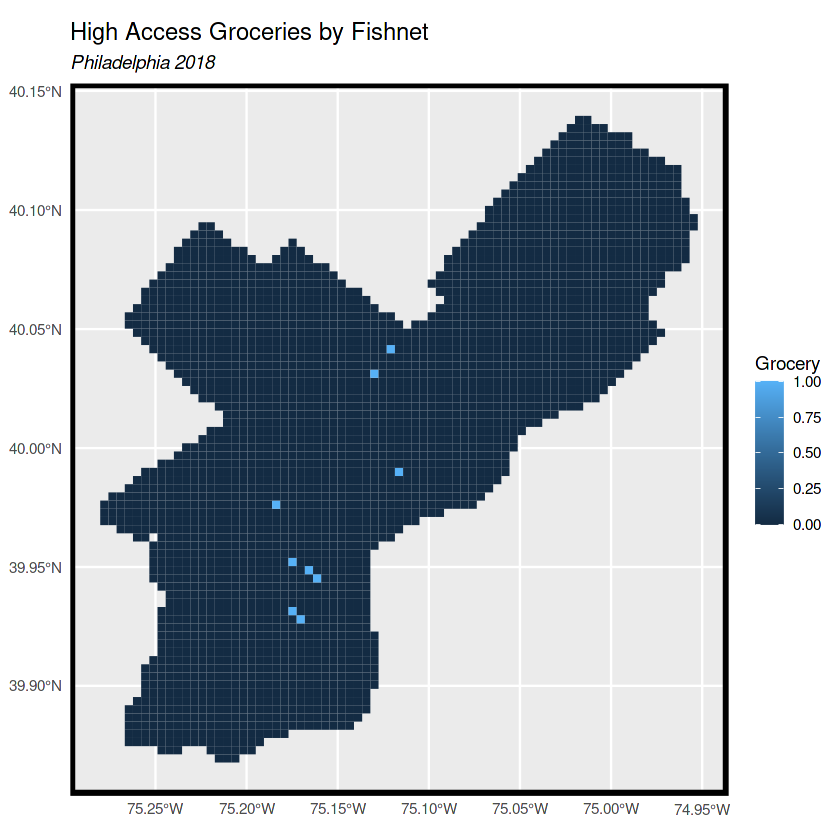

In [22]:
# Grocery Store Access data
grocerystore <- st_read("http://data-phl.opendata.arcgis.com/datasets/53b8a1c653a74c92b2de23a5d7bf04a0_0.geojson") %>%
    st_transform('EPSG:3857') %>%
    rename(GEOID=GEOID10)

grocerystore1 <- filter(grocerystore, HPSS_ACCESS == 'Moderate or High Access') %>%
    st_as_sf(coords = c("Longitude", "Latitude"), crs=4326, agr = "constant") %>%
    st_transform('EPSG:3857') %>%
    mutate(Legend = "Grocery")

grocery_net <- st_join(grocerystore1, fishnet, join=st_within) %>%
    st_drop_geometry() %>%
    group_by(uniqueID, Legend) %>%
    summarize(count = n()) %>% # we can also do vehicle availability
    full_join(fishnet) %>%
    spread(Legend, count, fill=0) %>%
    st_sf() %>%
    dplyr::select(- `<NA>`) %>%
    na.omit() %>%
    ungroup()

ggplot() +
    geom_sf(data = grocery_net, aes(fill=Grocery), color=NA) +
    scale_color_manual(values = c("constructionpalette")) +
    labs(title = 'High Access Groceries by Fishnet', subtitle = "Philadelphia 2018")+
    mapTheme()

another characteristic of a hipster neighborhood is prescence of nature and greenery

Reading layer `10404372-cab7-463f-9ae9-e6ad1c48f9ae2020330-1-pgb69a.1det' from data source `/kaggle/input/treecanopy/PPR_Tree_Canopy_Points_2015.geojson' 
  using driver `GeoJSON'
Simple feature collection with 2480 features and 2 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -75.26242 ymin: 39.88839 xmax: -74.95928 ymax: 40.13636
Geodetic CRS:  WGS 84


`summarise()` has grouped output by 'uniqueID'. You can override using the
`.groups` argument.
Joining, by = "uniqueID"


NULL

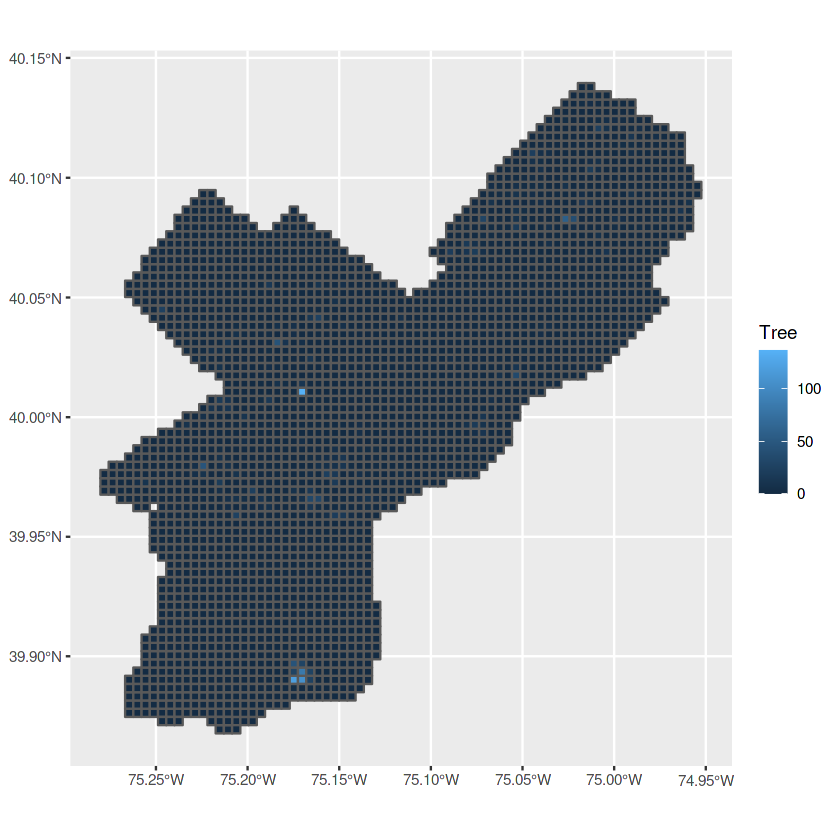

In [23]:
# number of trees per grid cell

treeinventory <- st_read("../input/treecanopy/PPR_Tree_Canopy_Points_2015.geojson") %>%
    st_transform('EPSG:3857') %>%
    mutate(Legend = "Tree")

# Spatial join of points to fishnets
treeinventory_net <- st_join(treeinventory, fishnet, join=st_within) %>%
    st_drop_geometry() %>%
    group_by(uniqueID, Legend) %>%
    summarize(count = n()) %>%
    full_join(fishnet) %>%
    spread(Legend, count, fill=0) %>%
    st_sf() %>%
    dplyr::select(- `<NA>`) %>%
    na.omit() %>%
    ungroup()

treeinventory_net$Tree = as.numeric(treeinventory_net$Tree)
treeinventory_net <- treeinventory_net %>%
    mutate(Legend = "Tree")

ggplot() +
    geom_sf(data = treeinventory_net, aes(fill=Tree)) +
#     I want to create range of values from 0-480 to color
    scale_alpha_manual(values="Tree")
    labs(title = "Tree Inventory by Fishnet", subtitle = "Philadelphia 2018") +
    mapTheme()

## All Risk Factors by Fishnet

`summarise()` has grouped output by 'uniqueID'. You can override using the
`.groups` argument.
Joining, by = "uniqueID"


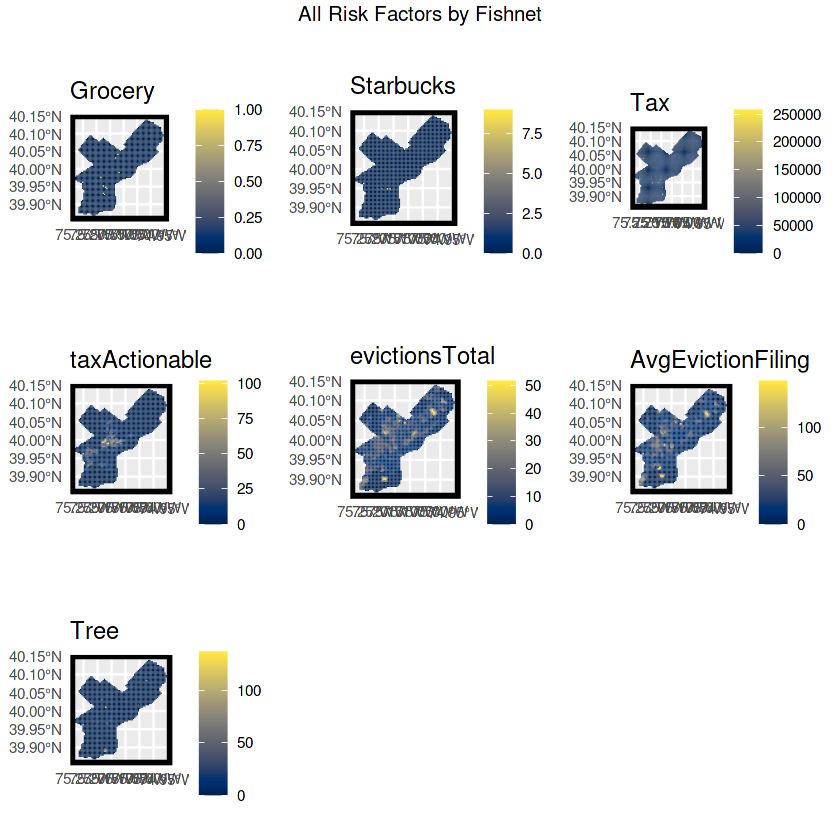

In [24]:
# All Risk Factors by Fishnet
starbucks_short<-starbucks%>%
  dplyr::select(geometry,Legend)

grocery_short<-grocerystore1%>%
  dplyr::select(geometry,Legend)

vars_net <- 
  rbind(starbucks_short, grocery_short) %>%
  st_join(., fishnet, join=st_within) %>%
  st_drop_geometry() %>%
  group_by(uniqueID, Legend) %>%
  summarize(count = n()) %>%
  full_join(fishnet) %>%
  spread(Legend, count, fill=0) %>%
  st_sf() %>%
  dplyr::select(-`<NA>`) %>%
  na.omit() %>%
  ungroup

vars_net.long <- 
  gather(vars_net, Variable, value, -geometry, -uniqueID)

tree_long <-
  gather(treeinventory_net, Variable, value, -geometry, -uniqueID,-Legend)%>%
  dplyr::select(-Legend)

allvars.long <-
  rbind(vars_net.long,tax_net.long, tax_net3.long,evictions_net.long,evictions_net3.long,tree_long)

vars <- unique(allvars.long$Variable)
mapList <- list()

for(i in vars){
  mapList[[i]] <- 
  ggplot() +
    geom_sf(data = filter(allvars.long, Variable == i), aes(fill=value), colour=NA) +
    scale_fill_viridis(name="", option="cividis") +
    labs(title=i) +
    mapTheme()}
  
do.call(grid.arrange,c(mapList, ncol=3, top="All Risk Factors by Fishnet"))

In [25]:
# Check correlation
evictions_net <- 
  evictions_net %>%
  st_join(., fishnet, join=st_within)

vars_net2<-
  vars_net%>%
  st_drop_geometry()%>%
  full_join(evictions_net, vars_net, by="uniqueID")%>%
  st_sf()%>%
  dplyr::select(-Legend)

evictions_net3 <- 
  evictions_net3 %>%
  st_join(., fishnet, join=st_within)

vars_net2 <-
  vars_net2%>%
  st_drop_geometry()%>%
  full_join(evictions_net3, vars_net2, by="uniqueID")%>%
  st_sf()%>%
  dplyr::select(-Legend)

vars_net2<-
  vars_net2%>%
  st_drop_geometry()%>%
  full_join(tax_net,vars_net2,by="uniqueID")%>%
  st_sf()

vars_net2<-
  vars_net2%>%
  st_drop_geometry()%>%
  full_join(tax_net3,vars_net2,by="uniqueID")%>%
  st_sf()

vars_net2 <-
  vars_net2%>%
  st_drop_geometry()%>%
  full_join(treeinventory_net,vars_net2,by="uniqueID")%>%
  st_sf()%>%
  dplyr::select(-Legend)

In [26]:
nn_function <- function(measureFrom,measureTo,k) {
  measureFrom_Matrix <-
    as.matrix(measureFrom)
  measureTo_Matrix <-
    as.matrix(measureTo)
  nn <-   
    get.knnx(measureTo, measureFrom, k)$nn.dist
  output <-
    as.data.frame(nn) %>%
    rownames_to_column(var = "thisPoint") %>%
    gather(points, point_distance, V1:ncol(.)) %>%
    arrange(as.numeric(thisPoint)) %>%
    group_by(thisPoint) %>%
    summarize(pointDistance = mean(point_distance)) %>%
    arrange(as.numeric(thisPoint)) %>% 
    dplyr::select(-thisPoint) %>%
    pull()
  
  return(output)  
}



In [27]:
st_c <- st_coordinates
st_coid <- st_centroid

#nn function requires both input layers to be points
vars_net2 <-
  vars_net2 %>%
  mutate(
    Starbucks.nn = nn_function(st_c(st_coid(vars_net2)), st_c(starbucks),1),
    Grocery.nn = nn_function(st_c(st_coid(vars_net2)), st_c(st_coid(grocerystore1)),1),
    Evictions.nn = nn_function(st_c(st_coid(vars_net2)), st_c(st_coid(evictions.geom)),3),
#     Tax.nn= nn_function(st_c(st_coid(vars_net2)), st_c(tax),3),
    Tree.nn= nn_function(st_c(st_coid(vars_net2)),st_c(treeinventory),3))

Warning message in st_centroid.sf(vars_net2):
“st_centroid assumes attributes are constant over geometries of x”
Warning message in st_centroid.sf(vars_net2):
“st_centroid assumes attributes are constant over geometries of x”
Warning message in st_centroid.sf(grocerystore1):
“st_centroid assumes attributes are constant over geometries of x”
Warning message in st_centroid.sf(vars_net2):
“st_centroid assumes attributes are constant over geometries of x”
Warning message in st_centroid.sf(evictions.geom):
“st_centroid assumes attributes are constant over geometries of x”
Warning message in st_centroid.sf(vars_net2):
“st_centroid assumes attributes are constant over geometries of x”


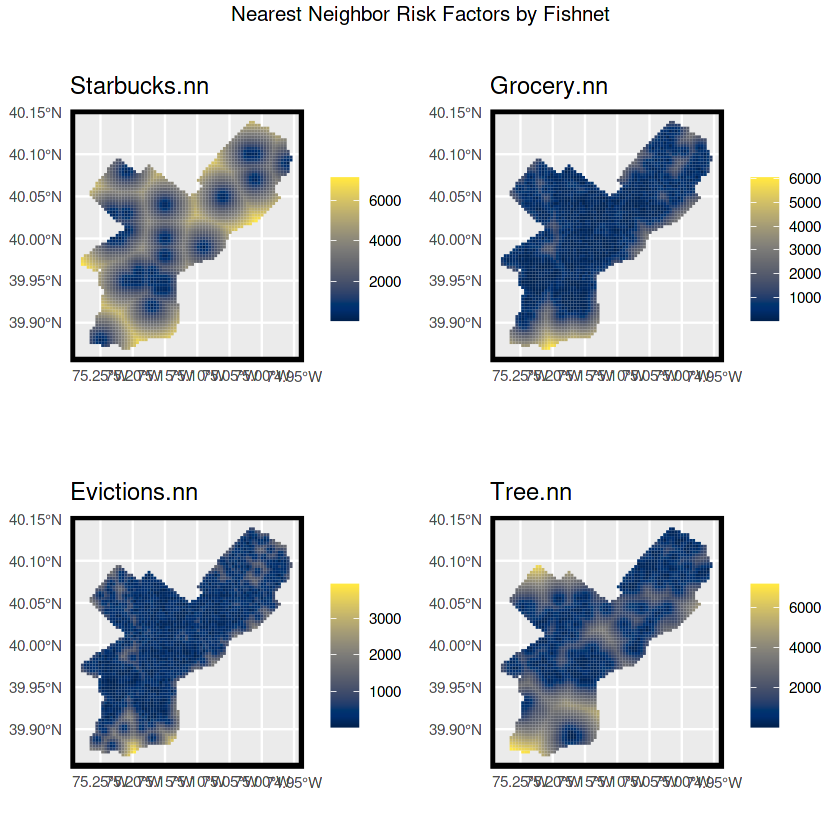

In [28]:
vars_net.long.nn <- 
  dplyr::select(vars_net2, ends_with(".nn")) %>%
  gather(Variable, value, -geometry)

vars2 <- unique(vars_net.long.nn$Variable)

mapList <- list()

for(i in vars2){
  mapList[[i]] <- 
    ggplot() +
    geom_sf(data = filter(vars_net.long.nn, Variable == i), aes(fill=value), colour=NA) +
    scale_fill_viridis(name="", option="cividis") +
    labs(title=i) +
    mapTheme()}

#NOTE: for tax.nn and eviction.nn fishnets now show counts instead of average evictions or total due
do.call(grid.arrange,c(mapList, ncol = 2, top = "Nearest Neighbor Risk Factors by Fishnet"))

starbucks and grocery store locations are more favorable because there is more information per grid cell

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”
Warning message in st_centroid.sf(vars_net2):
“st_centroid assumes attributes are constant over geometries of x”


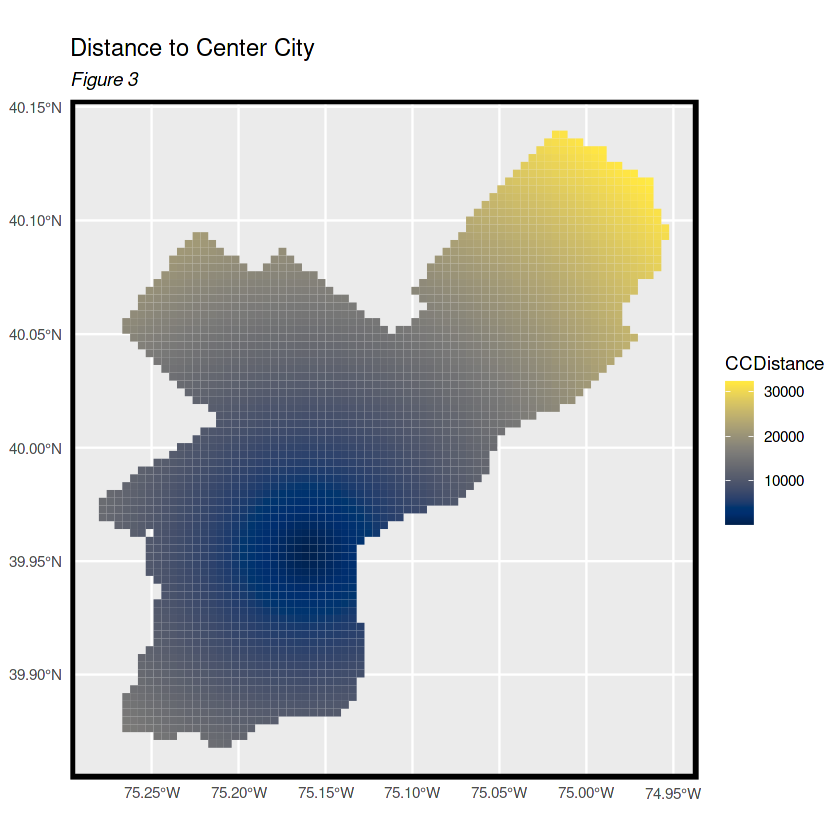

In [29]:
# Distance to city center
cityhall <-
  filter(neighborhoods, name == "CENTER_CITY") %>%
  st_centroid()

vars_net2$CCDistance = st_distance(st_centroid(vars_net2), cityhall) %>%
    as.numeric()

ggplot() +
    geom_sf(data = vars_net2, aes(fill = CCDistance), color=NA) +
    scale_fill_viridis(option="cividis") +
    labs(title = "Distance to Center City", subtitle = "Figure 3") +
    mapTheme()

In [30]:
# final join for all of our features

final_net <- left_join(permit_net, st_drop_geometry(vars_net2), by="uniqueID")

final_net <- st_centroid(final_net) %>%
    st_join(dplyr::select(neighborhoods, name)) %>%
    st_drop_geometry() %>%
    left_join(dplyr::select(final_net, geometry, uniqueID)) %>%
    st_sf() %>%
    na.omit()

Warning message in st_centroid.sf(final_net):
“st_centroid assumes attributes are constant over geometries of x”
Joining, by = "uniqueID"


## Exploring Spatial Processes

### Local Moran's I

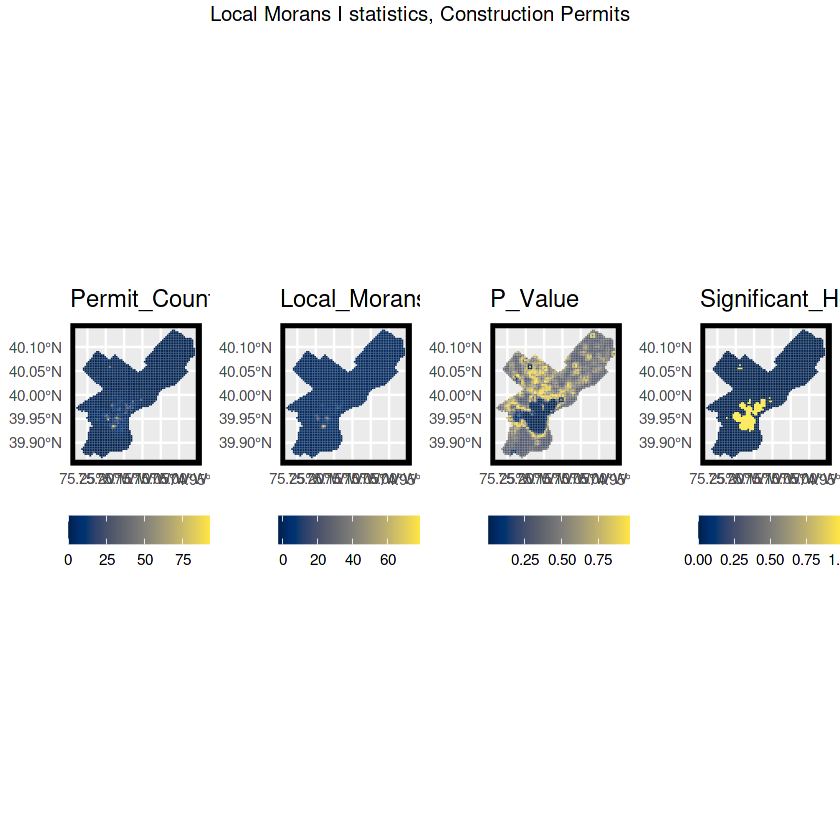

In [31]:
#  creating queen weight neighnors for Moran's I
final_net.nb <- poly2nb(as_Spatial(final_net), queen=TRUE)
final_net.weights <- nb2listw(final_net.nb, style="W", zero.policy=TRUE)

#Running Local Moran's I
final_net.localMorans <- 
  cbind(
    as.data.frame(localmoran(final_net$countPermit, final_net.weights)),
    as.data.frame(final_net)) %>% 
  st_sf() %>%
  dplyr::select(Permit_Count = countPermit, 
                Local_Morans_I = Ii, 
                P_Value = `Pr(z != E(Ii))`) %>%
  mutate(Significant_Hotspots = ifelse(P_Value <= 0.005, 1, 0)) %>% #change pvalue?
  gather(Variable, Value, -geometry)

vars <- unique(final_net.localMorans$Variable)
varList <- list()

for(i in vars){
  varList[[i]] <- 
    ggplot() +
    geom_sf(data = filter(final_net.localMorans, Variable == i), 
            aes(fill = Value), colour=NA) +
    scale_fill_viridis(name="", option="cividis") +
    labs(title=i) +
    mapTheme() + theme(legend.position="bottom")}

do.call(grid.arrange,c(varList, ncol = 4, top = "Local Morans I statistics, Construction Permits"))

There is a significant clustering in the Center City and surrounding neighborhoods. This will help us during the generalizability of our model.
A good model should be able to predict in the hotspots as well as in the coldspots.

In [32]:
colnames(final_net.localMorans)

[1] "Variable" "Value"    "geometry"

Warning message in st_centroid.sf(final_net):
“st_centroid assumes attributes are constant over geometries of x”
Warning message in st_centroid.sf(filter(final_net, Permit.isSig == 1)):
“st_centroid assumes attributes are constant over geometries of x”


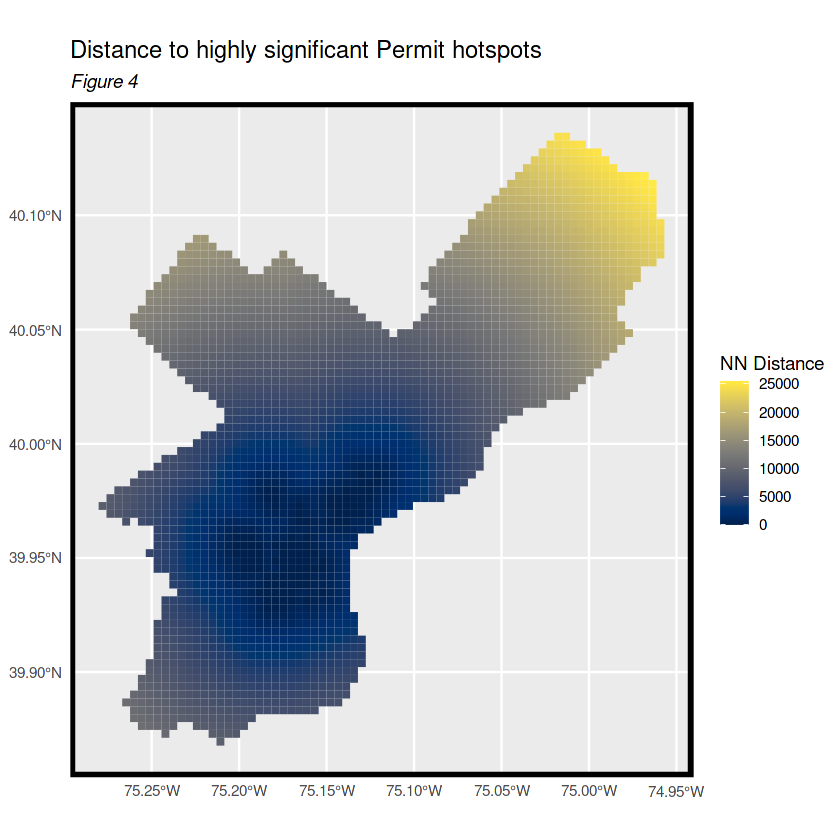

In [33]:
# significance to hotspots
final_net <- 
    final_net %>%
    mutate(Permit.isSig = ifelse(localmoran(final_net$countPermit, final_net.weights)[,5] <= 0.00001, 1, 0)) %>%
    mutate(Permit.isSig.dist = nn_function(st_coordinates(st_centroid(final_net)), 
                                          st_coordinates(st_centroid(filter(final_net, Permit.isSig == 1))), 1))

ggplot() +
    geom_sf(data = final_net, aes(fill = Permit.isSig.dist), color=NA) +
    scale_fill_viridis(name="NN Distance", option = "cividis") +
    labs(title = "Distance to highly significant Permit hotspots", subtitle = "Figure 4") +
    mapTheme()

## Correlation Tests

In [34]:
colnames(final_net)

[1] "countPermit"       "uniqueID"          "cvID"             
 [4] "Grocery"           "Starbucks"         "evictionsTotal"   
 [7] "AvgEvictionFiling" "Tax"               "taxActionable"    
[10] "Tree"              "Starbucks.nn"      "Grocery.nn"       
[13] "Evictions.nn"      "Tree.nn"           "CCDistance"       
[16] "name"              "geometry"          "Permit.isSig"     
[19] "Permit.isSig.dist"

Warning message:
“attributes are not identical across measure variables;
they will be dropped”
`geom_smooth()` using formula 'y ~ x'



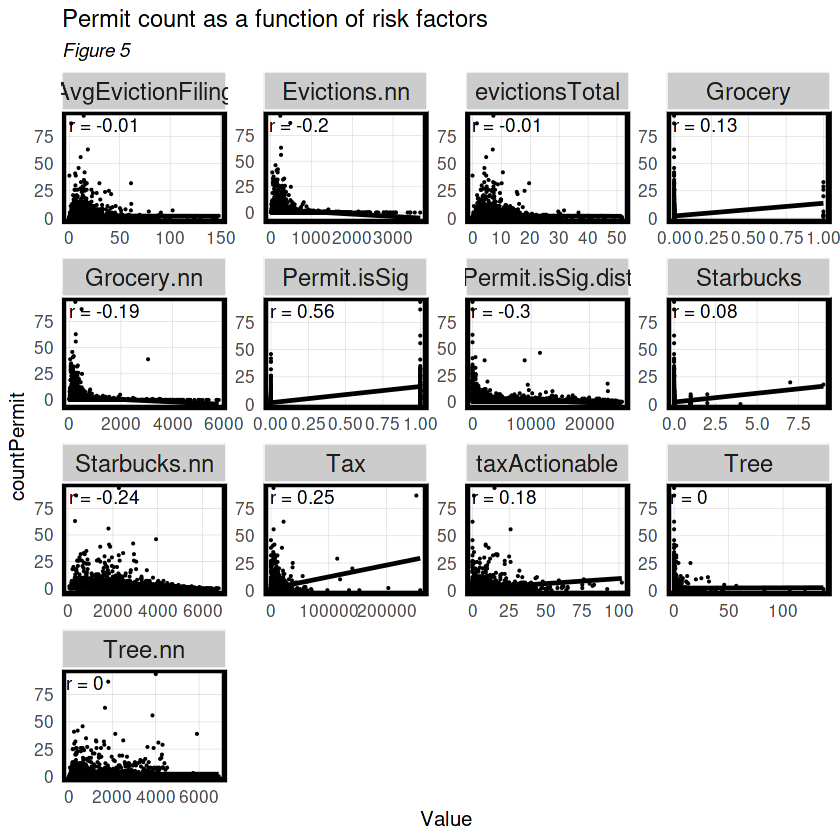

In [35]:
# see if our risk factors are highly associated to the count of newly filed construction permits

correlation.long <-
    st_drop_geometry(final_net) %>%
    dplyr::select(-uniqueID, -cvID, -CCDistance, -name) %>%
    gather(Variable, Value, -countPermit)

correlation.cor <-
  correlation.long %>%
  group_by(Variable) %>%
  summarize(correlation = cor(Value, countPermit, use = "complete.obs"))

ggplot(correlation.long, aes(Value, countPermit)) +
    geom_point(size = 0.1) +
    geom_text(data = correlation.cor, aes(label = paste("r =", round(correlation, 2))), x=-Inf, y=Inf, vjust = 1.5, hjust = -.1) +
    geom_smooth(method = "lm", se = FALSE, color ="black") +
    facet_wrap(~Variable, ncol = 4, scales = "free") +
    labs(title = "Permit count as a function of risk factors", subtitle = "Figure 5") +
    plotTheme()

Permit.isSig and Permit.isSig.dist are highly correlated which supports the statement that increasing values in one neighborhood affect its surrounding neighborhoods.
Starbucks locations (Starbucks.nn) and number of evictions (Evictions.nn) are more strongly correlatwd tha their point locations.

## Building the Model

In [36]:
# Poisson Regression because there are a lot of 0s in the distribution of DV
reg.vars <- c("Starbucks.nn", "Grocery.nn", "evictionsTotal", "AvgEvictionFiling", "taxActionable", "Tax", "Tree", "Tree.nn", "CCDistance")

# Adding in the spatial component of the dependent variable
reg.ss.vars <- c("Starbucks.nn", "Grocery.nn", "evictionsTotal", "AvgEvictionFiling", "taxActionable", "Tax", "Tree", "Tree.nn", "CCDistance", "Permit.isSig.dist")

## Cross-validated Poisson Regression

In [37]:
crossValidate <- function(dataset, id, dependentVariable, indVariables) {
  
  allPredictions <- data.frame()
  cvID_list <- unique(dataset[[id]])
  
  for (i in cvID_list) {
    
    thisFold <- i
    cat("This hold out fold is", thisFold, "\n")
    
    fold.train <- filter(dataset, dataset[[id]] != thisFold) %>% as.data.frame() %>% 
      dplyr::select(id, geometry, indVariables, dependentVariable)
    fold.test  <- filter(dataset, dataset[[id]] == thisFold) %>% as.data.frame() %>% 
      dplyr::select(id, geometry, indVariables, dependentVariable)
    
    regression <-
      glm(countPermit ~ ., family = "poisson", 
          data = fold.train %>% 
            dplyr::select(-geometry, -id))
    
    thisPrediction <- 
      mutate(fold.test, Prediction = predict(regression, fold.test, type = "response"))
    
    allPredictions <-
      rbind(allPredictions, thisPrediction)
    
  }
  return(st_sf(allPredictions))
}

In [38]:
reg.cv <- crossValidate(
  dataset = final_net,
  id = "cvID",
  dependentVariable = "countPermit",
  indVariables = reg.vars) %>%
  dplyr::select(cvID = cvID, countPermit, Prediction, geometry)

reg.ss.cv <- crossValidate(
  dataset = final_net,
  id = "cvID",
  dependentVariable = "countPermit",
  indVariables = reg.ss.vars) %>%
  dplyr::select(cvID = cvID, countPermit, Prediction, geometry)

reg.spatialCV <- crossValidate(
  dataset = final_net,
  id = "name",
  dependentVariable = "countPermit",
  indVariables = reg.vars) %>%
  dplyr::select(cvID = name, countPermit, Prediction, geometry)

reg.ss.spatialCV <- crossValidate(
  dataset = final_net,
  id = "name",
  dependentVariable = "countPermit",
  indVariables = reg.ss.vars) %>%
  dplyr::select(cvID = name, countPermit, Prediction, geometry)

This hold out fold is 39 


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(id)` instead of `id` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(indVariables)` instead of `indVariables` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(dependentVariable)` instead of `dependentVariable` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


This hold out fold is 40 
This hold out fold is 89 
This hold out fold is 15 
This hold out fold is 59 
This hold out fold is 60 
This hold out fold is 4 
This hold out fold is 37 
This hold out fold is 25 
This hold out fold is 91 
This hold out fold is 49 
This hold out fold is 109 
This hold out fold is 38 
This hold out fold is 75 
This hold out fold is 95 
This hold out fold is 113 
This hold out fold is 96 
This hold out fold is 78 
This hold out fold is 18 
This hold out fold is 102 
This hold out fold is 111 
This hold out fold is 90 
This hold out fold is 35 
This hold out fold is 53 
This hold out fold is 104 
This hold out fold is 57 
This hold out fold is 103 
This hold out fold is 108 
This hold out fold is 6 
This hold out fold is 23 
This hold out fold is 54 
This hold out fold is 63 
This hold out fold is 106 
This hold out fold is 3 
This hold out fold is 82 
This hold out fold is 84 
This hold out fold is 100 
This hold out fold is 41 
This hold out fold is 101 
This 

## Analyzing Results across Space

Compare the resulting predictions to the observations of reality t calculate the number of errors

In [39]:
reg.summary <-
    rbind(
    mutate(reg.cv, Error = Prediction - countPermit, Regression = "Random k-fold CV: Just Risk Factors"),
    mutate(reg.ss.cv, Error = Prediction - countPermit, Regression ="Random k-fold CV: Spatial Process"),
    mutate(reg.spatialCV, Error = Prediction - countPermit, Regression = "Spatial LOGO-CV: Just Risk Factors"),
    mutate(reg.ss.spatialCV,  Error = Prediction - countPermit, Regression = "Spatial LOGO-CV Spatial Process")) %>%
    st_sf()

`summarise()` has grouped output by 'Regression'. You can override using the
`.groups` argument.


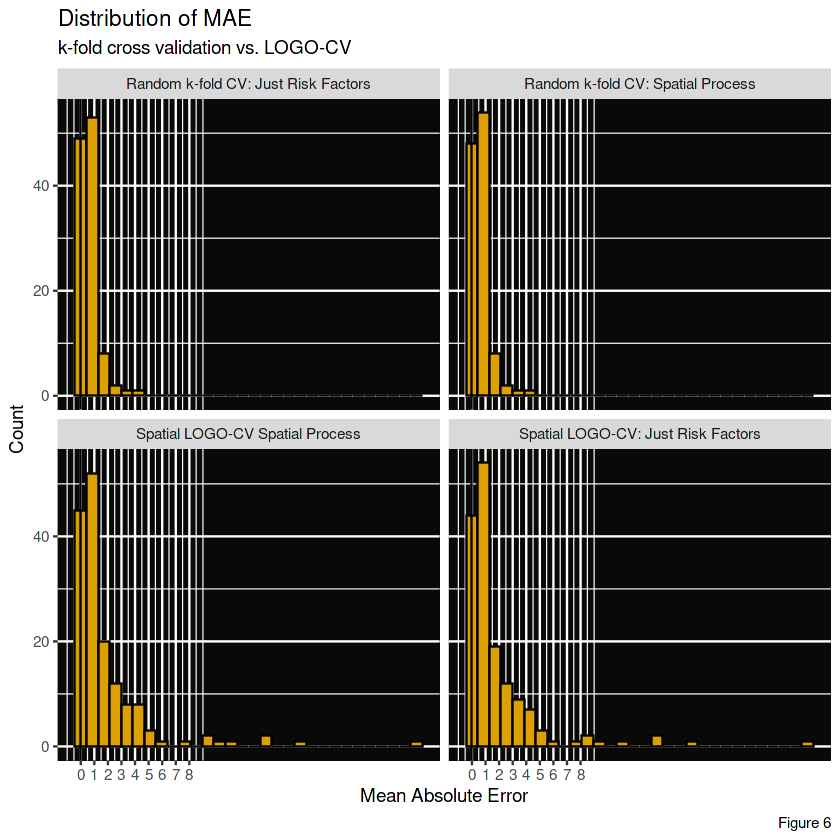

In [40]:
# plot mean absolute errors from each cross-validation

error_by_reg_and_fold <-
    reg.summary %>%
    group_by(Regression, cvID) %>%
    summarize(Mean_Error = mean(Prediction - countPermit, na.rm = T), 
             MAE = mean(abs(Mean_Error), na.rm=T),
             SD_MAE = mean(abs(Mean_Error), na.rm = T)) %>%
    ungroup ()

error_by_reg_and_fold %>%
    ggplot(aes(MAE)) +
    geom_histogram(bins = 30, color = "black", fill = '#de9f00') +
    facet_wrap(~Regression) +
    geom_vline(xintercept = 0) +
    scale_x_continuous(breaks = seq(0, 8, by =1)) +
    labs(title = "Distribution of MAE", subtitle = "k-fold cross validation vs. LOGO-CV", caption = "Figure 6", x="Mean Absolute Error", y="Count") +
    theme(panel.background = element_rect(fill = "#090a07"))

In [41]:
st_drop_geometry(error_by_reg_and_fold) %>%
  group_by(Regression) %>% 
    summarize(Mean_MAE = round(mean(MAE), 2),
              SD_MAE = round(sd(MAE), 2)) %>%
  kable() %>%
    kable_styling("striped", full_width = F) %>%
    row_spec(1, color = "white", background = "#383120") %>%
    row_spec(2, color = "black", background = "#de9f00") %>%
    row_spec(3, color = "white", background = "#383120") %>%
    row_spec(4, color = "black", background = "#de9f00")

<table class="table table-striped" style="width: auto !important; margin-left: auto; margin-right: auto;">
 <thead>
  <tr>
   <th style="text-align:left;"> Regression </th>
   <th style="text-align:right;"> Mean_MAE </th>
   <th style="text-align:right;"> SD_MAE </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;color: white !important;background-color: #383120 !important;"> Random k-fold CV: Just Risk Factors </td>
   <td style="text-align:right;color: white !important;background-color: #383120 !important;"> 0.68 </td>
   <td style="text-align:right;color: white !important;background-color: #383120 !important;"> 0.67 </td>
  </tr>
  <tr>
   <td style="text-align:left;color: black !important;background-color: #de9f00 !important;"> Random k-fold CV: Spatial Process </td>
   <td style="text-align:right;color: black !important;background-color: #de9f00 !important;"> 0.68 </td>
   <td style="text-align:right;color: black !important;background-color: #de9f00 !important;"> 

The results indicate the regression model with spatial features perform better than the one with just risk factors.
The k-fold regression performs better than the LOGO-CV regression

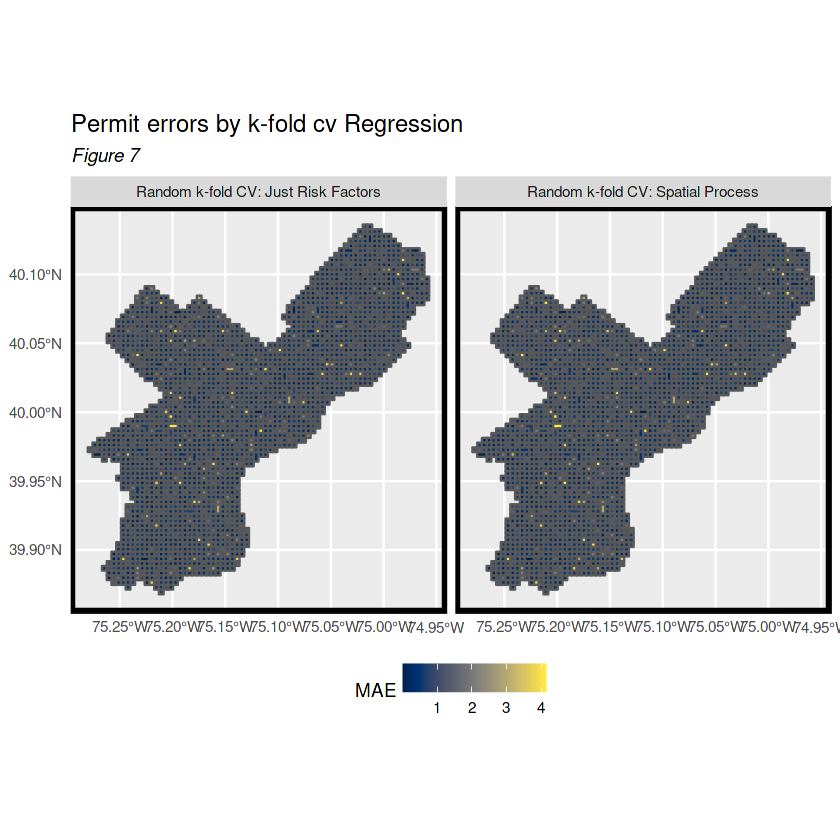

In [42]:
#Run with K fold
error_by_reg_and_fold %>%
  filter(str_detect(Regression, "k-fold")) %>%
  ggplot() +
    geom_sf(aes(fill = MAE)) +
    facet_wrap(~Regression) +
    scale_fill_viridis(option="cividis") +
    labs(title = "Permit errors by k-fold cv Regression",
         subtitle = "Figure 7") +
    mapTheme() + theme(legend.position="bottom")

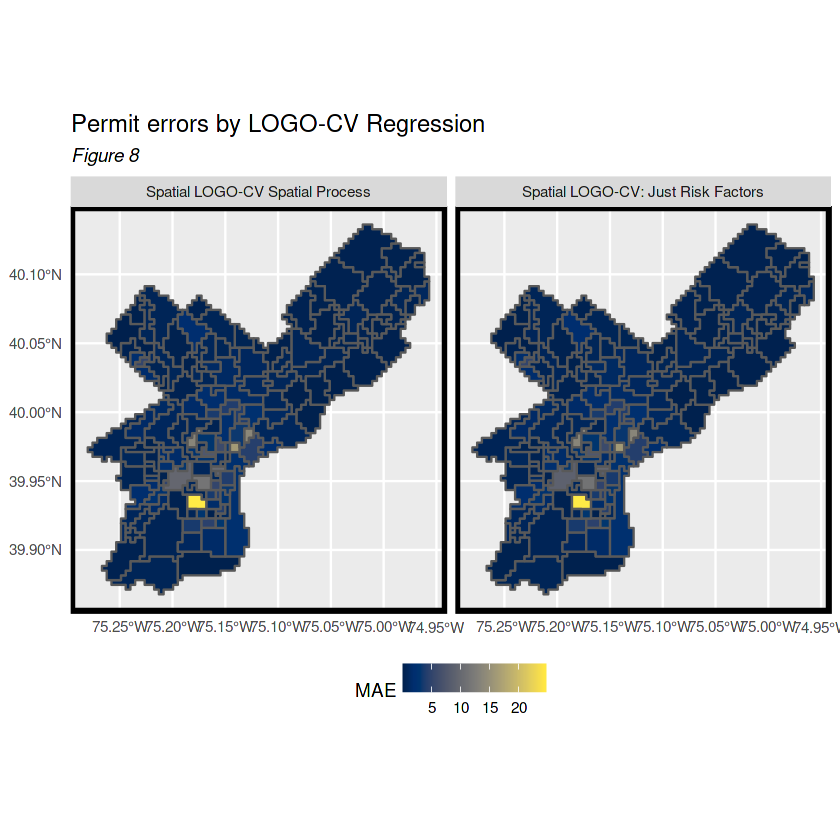

In [43]:
#Run with LOGO-CV
error_by_reg_and_fold %>%
  filter(str_detect(Regression, "LOGO")) %>%
  ggplot() +
    geom_sf(aes(fill = MAE)) +
    facet_wrap(~Regression) +
    scale_fill_viridis(option="cividis") +
    labs(title = "Permit errors by LOGO-CV Regression",
         subtitle = "Figure 8") +
    mapTheme() + theme(legend.position="bottom")

calculate a Local Moran's I statistic to examine how the model performs in hotspots vs coldspots

In [44]:
neighborhood.weights <-
  filter(error_by_reg_and_fold, Regression == "Spatial LOGO-CV Spatial Process") %>%
    group_by(cvID) %>%
      poly2nb(as_Spatial(.), queen=TRUE) %>%
      nb2listw(., style="W", zero.policy=TRUE)

filter(error_by_reg_and_fold, str_detect(Regression, "LOGO"))  %>% 
    st_drop_geometry() %>%
    group_by(Regression) %>%
    summarize(Morans_I = moran.mc(abs(Mean_Error), neighborhood.weights, 
                                 nsim = 999, zero.policy = TRUE, 
                                 na.action=na.omit)[[1]],
              p_value = moran.mc(abs(Mean_Error), neighborhood.weights, 
                                 nsim = 999, zero.policy = TRUE, 
                                 na.action=na.omit)[[3]]) %>%
  kbl(caption = "Moran's I and p-value of Spatial LOGO-CV") %>%
  kable_styling() %>%
  row_spec(1, color = "white", background = "#383120") %>%  
  row_spec(2, color = "black", background = "#de9f00") 

<table class="table" style="margin-left: auto; margin-right: auto;">
<caption>Moran's I and p-value of Spatial LOGO-CV</caption>
 <thead>
  <tr>
   <th style="text-align:left;"> Regression </th>
   <th style="text-align:right;"> Morans_I </th>
   <th style="text-align:right;"> p_value </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;color: white !important;background-color: #383120 !important;"> Spatial LOGO-CV Spatial Process </td>
   <td style="text-align:right;color: white !important;background-color: #383120 !important;"> 0.1290306 </td>
   <td style="text-align:right;color: white !important;background-color: #383120 !important;"> 0.009 </td>
  </tr>
  <tr>
   <td style="text-align:left;color: black !important;background-color: #de9f00 !important;"> Spatial LOGO-CV: Just Risk Factors </td>
   <td style="text-align:right;color: black !important;background-color: #de9f00 !important;"> 0.1251040 </td>
   <td style="text-align:right;color: black !important;backgroun

The results indicate that there is more spatial variation with our spatial features included

`summarise()` has grouped output by 'Regression'. You can override using the
`.groups` argument.


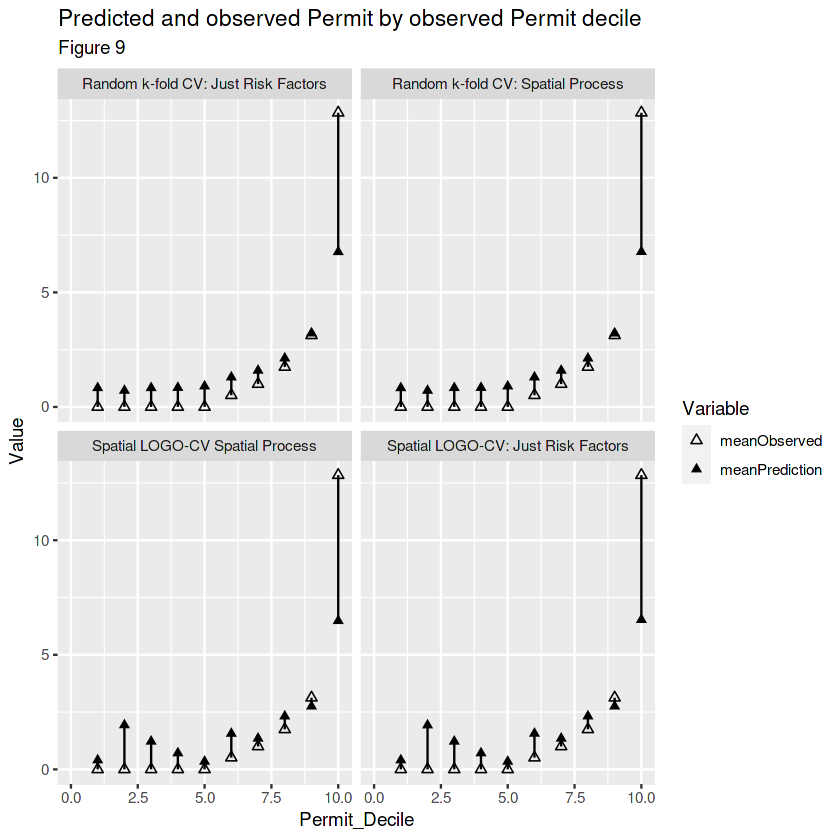

In [45]:
# plot predictions and observations

st_drop_geometry(reg.summary) %>%
    group_by(Regression) %>%
    mutate(Permit_Decile = ntile(countPermit, 10)) %>%
    group_by(Regression, Permit_Decile) %>%
    summarize(meanObserved = mean(countPermit, na.rm = T),
             meanPrediction = mean(Prediction, na.rm = T)) %>%
    gather(Variable, Value, -Regression, -Permit_Decile) %>%        
    ggplot(aes(Permit_Decile, Value, shape = Variable)) +
        geom_point(size = 2) + geom_path(aes(group = Permit_Decile), colour = "black") +
        scale_shape_manual(values = c(2, 17)) +
        facet_wrap(~Regression) + xlim(0,10) +
        labs(title = "Predicted and observed Permit by observed Permit decile",
           subtitle = "Figure 9")

The results actually show that our model tends to under-predict in neighborhoods of high concentrations of construcction permits and over predict in neighborhoods of low concentration.

### Generalizability by Neighborhood context

In [46]:
# # Generalize to an income context. Below Median Income of $46,116 or above

# tracts18 <- get_acs(geography = "tract", variables = c("B06011_001"),
#                    year = 2018, state = 43, county = 101, geometry =T) %>%
#     st_transform('EPSG:3857') %>%
#     dplyr::select(variable, estimate, GEOID) %>%
#     spread(variable, estimate) %>%
#     rename(MedianIncome = "B06011_001") %>%
#     mutate(#percentWhite = NumberWhites / TotalPop,
#          IncomeContext = ifelse(MedianIncome > 46116, "Above_Median_Income", "Below_Median_Income")) %>%
#     .[neigborhoods, ]

#   ggplot()+
#     geom_sf(data=tracts18, aes(fill=IncomeContext))+
#     #scale_color_viridis()+
#     labs(title="Income Context in Philadelphia\n2018",
#          subtitle = "Figure 9")+
#     mapTheme()

In [47]:
# reg.summary %>% 
#   filter(str_detect(Regression, "LOGO")) %>%
#     st_centroid() %>%
#     st_join(tracts18) %>%
#     na.omit() %>%
#       st_drop_geometry() %>%
#       group_by(Regression, IncomeContext) %>%
#       summarize(mean.Error = mean(Error, na.rm = T)) %>%
#       spread(IncomeContext, mean.Error) %>%
#       kable(caption = "Mean Error by neighborhood Income context") %>%
#         kable_styling("striped", full_width = F) %>%
#   row_spec(1, color = "white", background = "#383120") %>%  
#   row_spec(2, color = "black", background = "#de9f00") 

## Analyzing Results Across Time
we create maps to analyze the accuracy and generalizability of our model across time.

Warning message in ppp(X[, 1], X[, 2], window = win, check = check):
“168 out of 5019 points had NA or NaN coordinate values, and were discarded”
Warning message:
“data contain duplicated points”


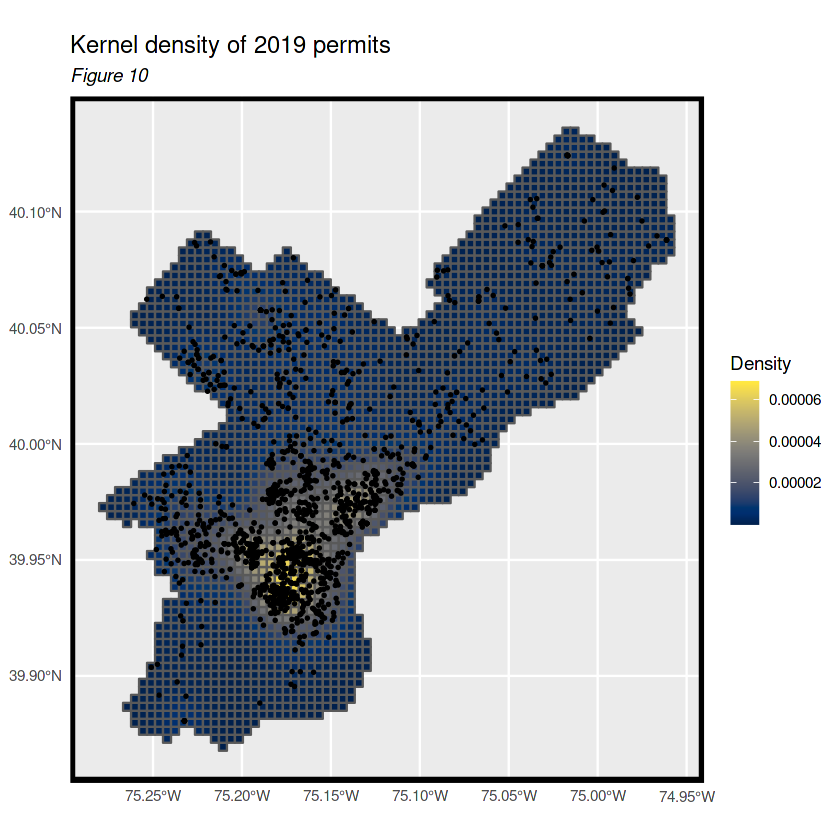

In [48]:
permit_ppp <- as.ppp(st_coordinates(permits), W = st_bbox(final_net))
permit_KD <- density.ppp(permit_ppp, 1000)

as.data.frame(permit_KD) %>%
  st_as_sf(coords = c("x", "y"), crs = st_crs(final_net)) %>%
  aggregate(., final_net, mean) %>%
   ggplot() +
     geom_sf(aes(fill=value)) +
     geom_sf(data = sample_n(permits, 1500), size = .5) +
     scale_fill_viridis(name = "Density", option="cividis") +
     labs(title = "Kernel density of 2019 permits",
          subtitle = "Figure 10") +
     mapTheme()

In [49]:
permits19 <-  st_read("https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+permits+WHERE+permitissuedate+>=+'2019-01-01'+AND+permitissuedate+<+'2020-01-01'AND+typeofwork+=+'NEW+CONSTRUCTION'&filename=permits&format=geojson&skipfields=cartodb_id")%>%
  st_transform('EPSG:3857')%>%
  distinct() %>%
  .[fishnet,]

Reading layer `OGRGeoJSON' from data source 
  `https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+permits+WHERE+permitissuedate+>=+'2019-01-01'+AND+permitissuedate+<+'2020-01-01'AND+typeofwork+=+'NEW+CONSTRUCTION'&filename=permits&format=geojson&skipfields=cartodb_id' 
  using driver `GeoJSON'
replacing null geometries with empty geometries
Simple feature collection with 10281 features and 31 fields (with 411 geometries empty)
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -75.27366 ymin: 39.88057 xmax: -74.96128 ymax: 40.13522
Geodetic CRS:  WGS 84


In [50]:
permit_ppp <- as.ppp(st_coordinates(permits), W = st_bbox(final_net))
permit_KD <- density.ppp(permit_ppp, 1000)

permit_KDE_sf <- as.data.frame(permit_KD) %>%
  st_as_sf(coords = c("x", "y"), crs = st_crs(final_net)) %>%
  aggregate(., final_net, mean) %>%
  mutate(label = "Kernel Density",
         Risk_Category = ntile(value, 100),
         Risk_Category = case_when(
           Risk_Category >= 90 ~ "90% to 100%",
           Risk_Category >= 70 & Risk_Category <= 89 ~ "70% to 89%",
           Risk_Category >= 50 & Risk_Category <= 69 ~ "50% to 69%",
           Risk_Category >= 30 & Risk_Category <= 49 ~ "30% to 49%",
           Risk_Category >= 1 & Risk_Category <= 29 ~ "1% to 29%")) %>%
  cbind(
    aggregate(
      dplyr::select(permits19) %>% mutate(permitCount = 1), ., sum) %>%
    mutate(permitCount = replace_na(permitCount, 0))) %>%
  dplyr::select(label, Risk_Category, permitCount)

Warning message in ppp(X[, 1], X[, 2], window = win, check = check):
“168 out of 5019 points had NA or NaN coordinate values, and were discarded”
Warning message:
“data contain duplicated points”


we use the predictions from LOGO-CV with the spatial features because this is the model we expected to perform the best

In [51]:
permit_risk_sf <-
  filter(reg.summary, Regression == "Spatial LOGO-CV Spatial Process") %>%
  mutate(label = "Risk Predictions",
         Risk_Category = ntile(Prediction, 100),
         Risk_Category = case_when(
           Risk_Category >= 90 ~ "90% to 100%",
           Risk_Category >= 70 & Risk_Category <= 89 ~ "70% to 89%",
           Risk_Category >= 50 & Risk_Category <= 69 ~ "50% to 69%",
           Risk_Category >= 30 & Risk_Category <= 49 ~ "30% to 49%",
           Risk_Category >= 1 & Risk_Category <= 29 ~ "1% to 29%")) %>%
  cbind(
    aggregate(
      dplyr::select(permits19) %>% mutate(permitCount = 1), ., sum) %>%
      mutate(permitCount = replace_na(permitCount, 0))) %>%
  dplyr::select(label,Risk_Category, permitCount)

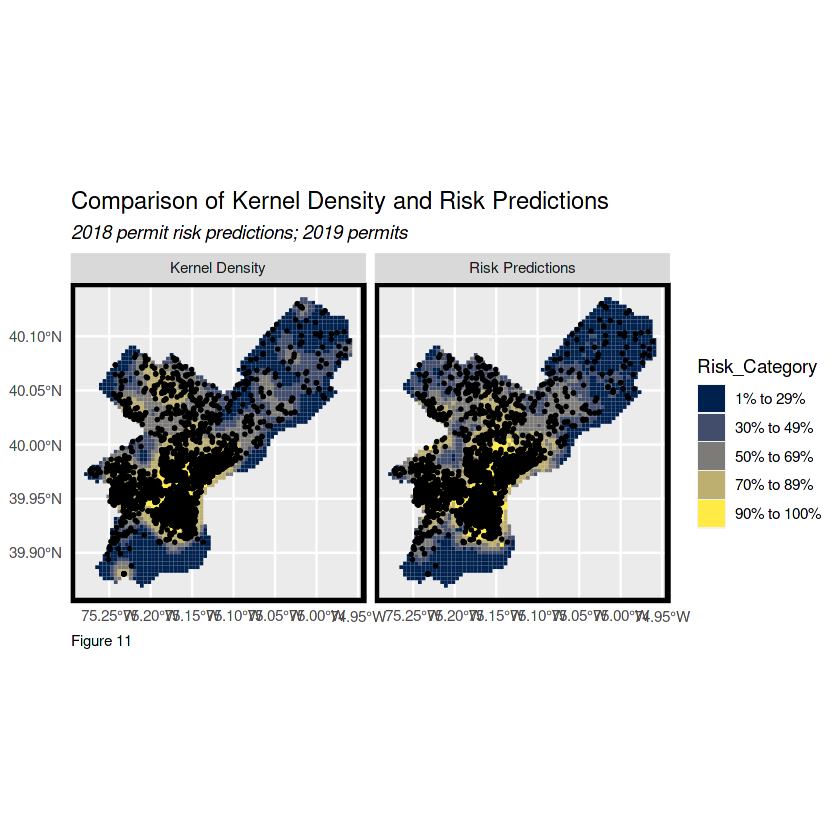

In [52]:
rbind(permit_KDE_sf, permit_risk_sf) %>%
  na.omit() %>%
  gather(Variable, Value, -label, -Risk_Category, -geometry) %>%
  ggplot() +
    geom_sf(aes(fill = Risk_Category), colour = NA) +
    geom_sf(data = sample_n(permits19, 3000), size = .5, colour = "black") +
    facet_wrap(~label, ) +
    scale_fill_viridis(discrete = TRUE, option="cividis") +
    labs(title="Comparison of Kernel Density and Risk Predictions",
         subtitle="2018 permit risk predictions; 2019 permits",
         caption = "Figure 11") +
    mapTheme()

Figure 11 shows a localized heat map from the risk predictions rather than the kernel density map.
Localization can not be understated as risk can vary form block to block and the resources needed for each follows the prediction.
In this approach rather than the Kernel density map allocating resources on a specific block or household level, the risk predictions model is more appropriate.

`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.


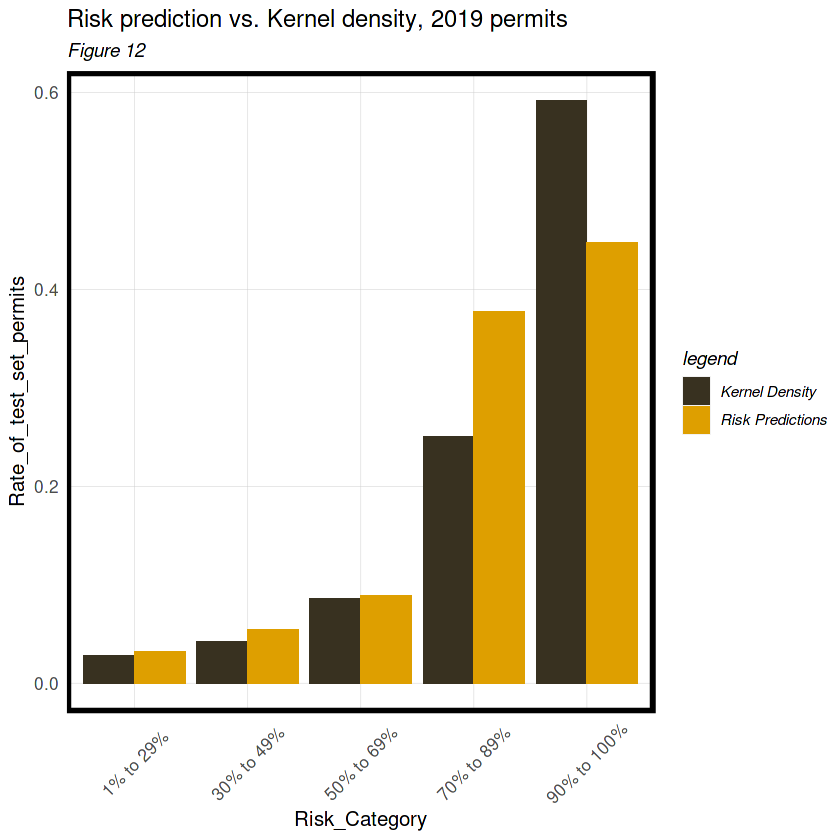

In [53]:
rbind(permit_KDE_sf, permit_risk_sf) %>%
  st_set_geometry(NULL) %>% na.omit() %>%
  gather(Variable, Value, -label, -Risk_Category) %>%
  group_by(label, Risk_Category) %>%
  summarize(countPermits = sum(Value)) %>%
  ungroup() %>%
  group_by(label) %>%
  mutate(Rate_of_test_set_permits = countPermits / sum(countPermits)) %>%
    ggplot(aes(Risk_Category,Rate_of_test_set_permits)) +
      geom_bar(aes(fill=label), position="dodge", stat="identity") +
      scale_fill_manual ("legend", values = c("Kernel Density" = "#383120", "Risk Predictions" = "#de9f00")) +
      labs(title = "Risk prediction vs. Kernel density, 2019 permits",
           subtitle = "Figure 12") +
      plotTheme() + theme(axis.text.x = element_text(angle = 45, vjust = 0.5))

The bar chart above displays the accuracy of our predictions. In the riskiest category (90% to 100%), kernel density predicts more accurately while in the second riskiest, the risk prediction model does better. However at the other categories, bars are basically even.
Later on, I would like to see risk predictions do substantially better in order to prove its effectiveness over kernel density.

In [54]:
knit('knitr-minimal.Rhtml')

Warning message in file(con, "r"):
"cannot open file 'knitr-minimal.Rhtml': No such file or directory"


ERROR: Error in file(con, "r"): cannot open the connection
